In [64]:
import os
import threading
import time


import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam

from kfp import construct_A, construct_B, diffusion_coeff, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, logsumexp
from network import ScoreNet
#from net_network import UNet

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
    os.system("make -C ../sparse_gaussian_elimination a.so")


cifar = CIFAR10('.', download=True)


# download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

Files already downloaded and verified


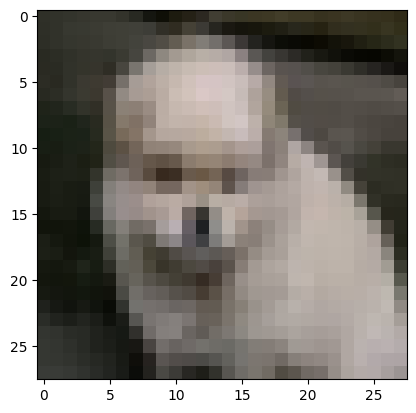

In [65]:

# cifar_data_grey = [torch.Tensor(np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28))))]
cifar_data = [np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("RGB").crop((0, 0, 28, 28)))]
plt.imshow(cifar_data[0])
cifar_data = [torch.Tensor(np.moveaxis(cifar_data[0], 2, 0))]
n_data = len(cifar_data)

In [66]:
## construct the grid and Initial values
batch_size = 32
N = 10
H = 28
W = 28
epoch = 60
eps = 1e-6

channels = 3

t = np.linspace(eps, 1, N)
dt = 1/N

sigma = 25

# create model
model_score = ScoreNet(H=H, W=W, in_channels=channels)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)
mm_scaler = MinMaxScaler()
model_score.train();

scores = np.zeros((N,channels, H, W), dtype=np.float32)

In [67]:
params = {"bandwidth": np.logspace(-1, 1, 20)}
kdes = np.full((n_data, channels), None)

R = construct_R(int(H/2), int(H))
R_block = sp.linalg.block_diag(*([R] * (N-1)))
sparse_R_block = sp.sparse.block_diag(([R] * (N-1)))
P = construct_P(R)
P_block = sp.linalg.block_diag(*([P] * (N-1)))
sparse_P_block = sp.sparse.block_diag(([P] * (N-1)))
def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
    data = data[channel]
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
    
    if not kdes[data_idx, channel]:
      grid = GridSearchCV(KernelDensity(), params)
      kdes[data_idx, channel] = grid.fit(data.ravel()[:, None]) # 0.7 sec
    
    m[channel][0] = kdes[data_idx, channel].score_samples(data.ravel()[:, None])
    del_m[channel][0] = np.diff(m[channel][0].ravel(), axis=0, prepend=m[channel][0,0])
    
    # we normalize for sigma to ensure the dynamics doesn't blow up
    As = []
    for i, t_ in enumerate(random_t, 1):
      A = construct_A(dx, dy, t_ - time_[i-1], np.zeros((H, W)), sigma_[i], scores[i][channel], H, W)
      As.append(A)

    A_block = sp.linalg.block_diag(*As)
    for i, t_ in enumerate(random_t, 1):
      if i == 1:
        continue
      A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])
    
    
    B = construct_B(dx, dy, time_[1] - time_[0], m[channel][0], np.zeros((H, W)), sigma_[1], scores[i][channel])
    B_block = np.zeros(A_block.shape[0])
    B_block[:H*W] = B
    
    # update m (pre-smoothing)
    
    m[channel][1:] = gauss_seidel(A_block, B_block, scores[1:, channel].flatten()).reshape(((N-1), H*W)) # 0.4
    
    
    ##### 0.5
    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@(m[channel][1:]).flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)

    sparse_A_block = sparse.csr_matrix(A_block)
    
    A_c = (sparse_R_block@sparse_A_block@sparse_P_block) # 0.5
    
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sp_sparse')
    
    # interpolate to fine grid: err = P_c@err_c
    err = P_block@err_c
    # we apply fine grid-correction
    m[channel][1:] = (m[channel][1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[channel][1:] = gauss_seidel(A_block, B_block, m[channel][1:].flatten()).reshape(((N-1), H*W))

    # we want to coarsen the score function to train on coarse data
    m_c[channel][1:] = (R_block@m[channel][1:].flatten()).reshape((-1, int(H*W/4)))

    # constructing the training data and labels
    for i, t_ in enumerate(random_t, 1):
      del_m[channel][i] = np.diff(m[channel][i].ravel(), axis=0, prepend=m[channel][i, 0])

    x = torch.tensor(mm_scaler.fit_transform(np.exp((-m[channel].ravel() - logsumexp(-m[channel].ravel())))[:, None])).reshape((N, 1, H, W))
    perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    train_x_data[:, channel] = perturbed_x[:, 0]
    train_y_data[:, channel] = torch.tensor(del_m[channel].astype(np.float32)).reshape((N, H, W))

    # generate coarse dataset
    x_c = torch.tensor(mm_scaler.fit_transform(np.exp((-m_c[channel].ravel() - logsumexp(-m_c[channel].ravel())))[:, None])).reshape((N, int(H/2), int(W/2)))
    perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None]
    train_xc_data[:, channel] = perturbed_xc


  0%|          | 0/60 [00:00<?, ?it/s]

time:  2.373457908630371


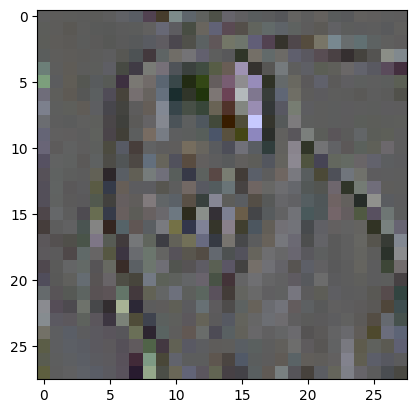

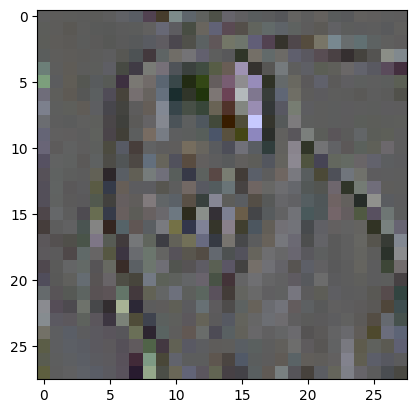

0.16804341971874237
0.13582462072372437


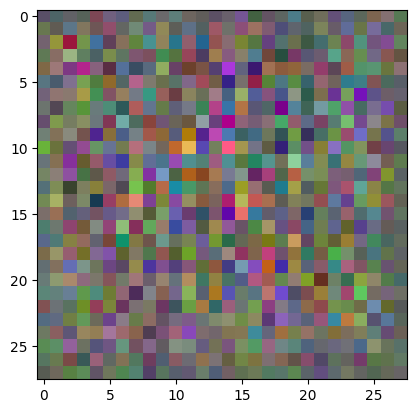

  2%|▏         | 1/60 [00:02<02:37,  2.67s/it]

time:  1.4666578769683838


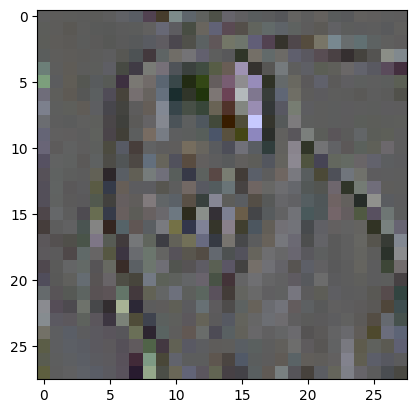

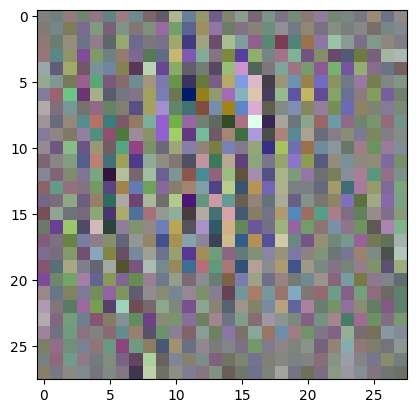

0.16051369905471802
0.1455625742673874


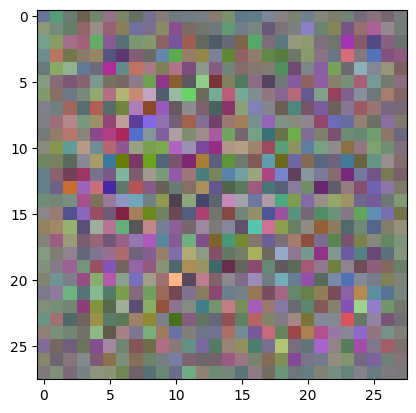

  3%|▎         | 2/60 [00:04<02:04,  2.15s/it]

time:  1.2032785415649414


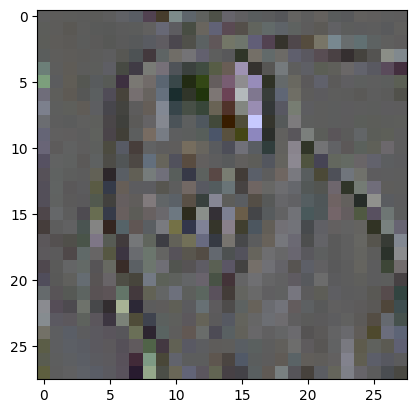

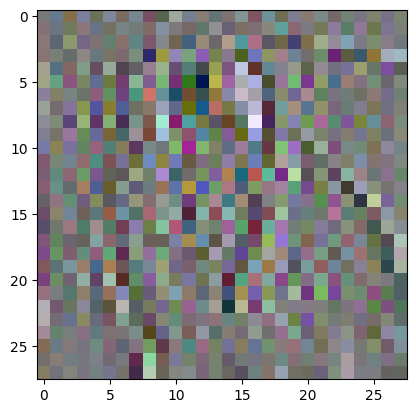

0.12380004674196243
0.12326828390359879


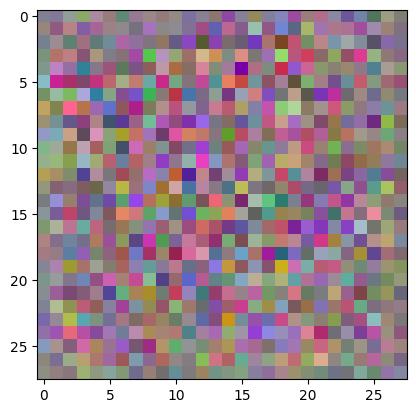

  5%|▌         | 3/60 [00:06<01:53,  1.99s/it]

time:  1.1915819644927979


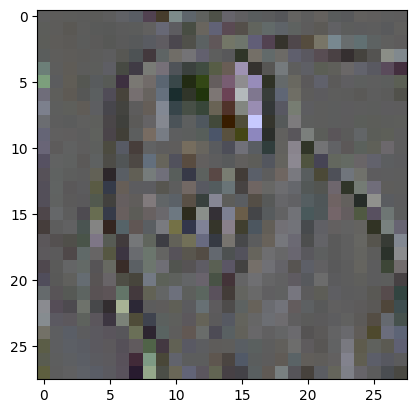

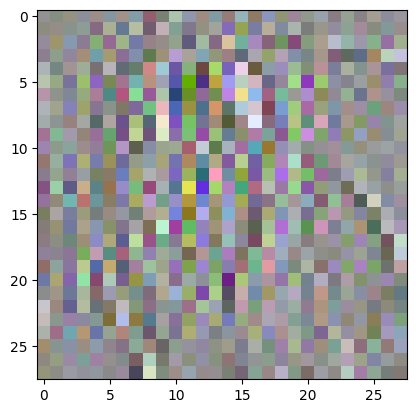

0.10490665584802628
0.11279016733169556


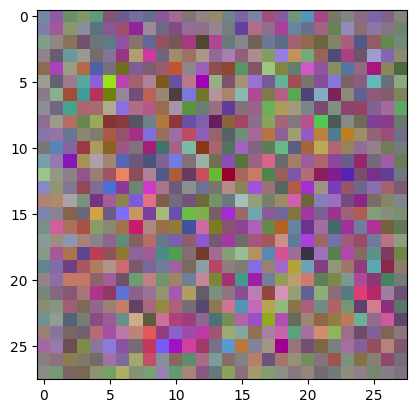

  7%|▋         | 4/60 [00:07<01:43,  1.85s/it]

time:  1.3991150856018066


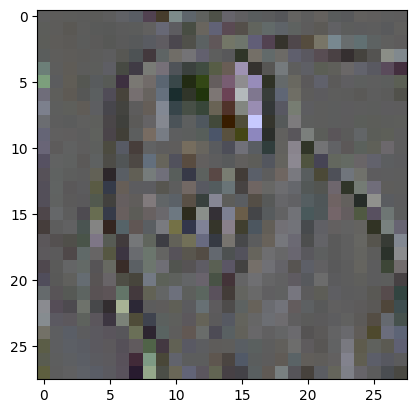

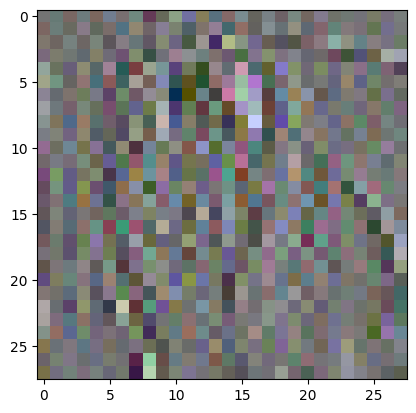

0.08561774343252182
0.09573335200548172


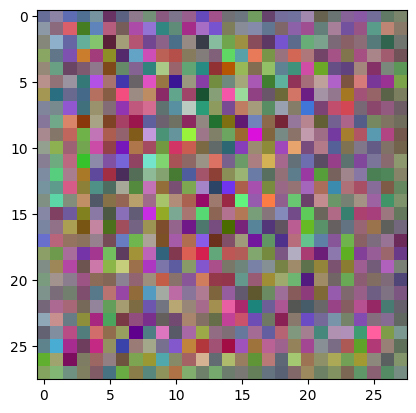

  8%|▊         | 5/60 [00:10<01:57,  2.14s/it]

time:  1.2282824516296387


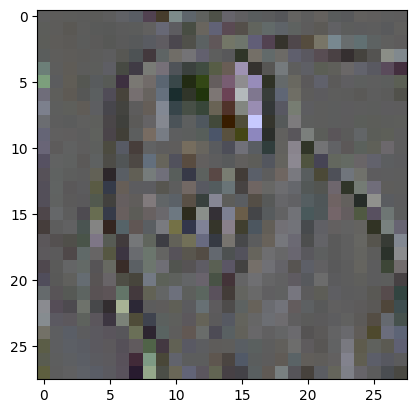

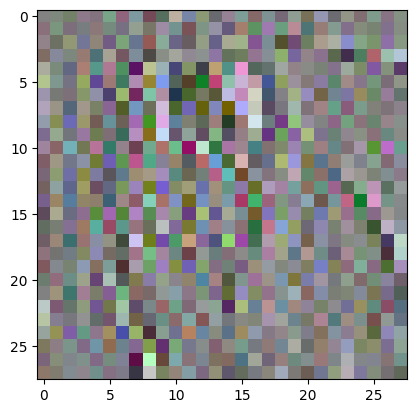

0.08865758031606674
0.09748425334692001


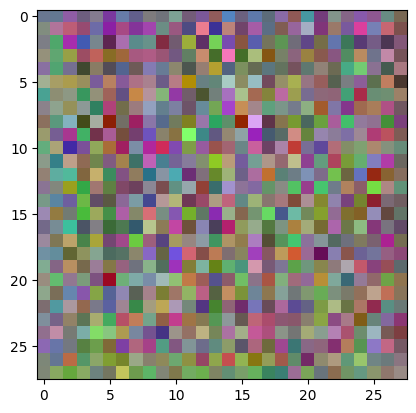

 10%|█         | 6/60 [00:12<01:55,  2.15s/it]

time:  1.1165227890014648


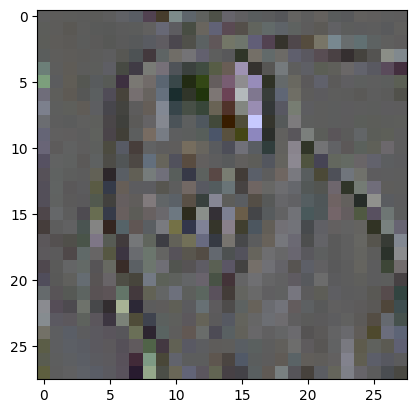

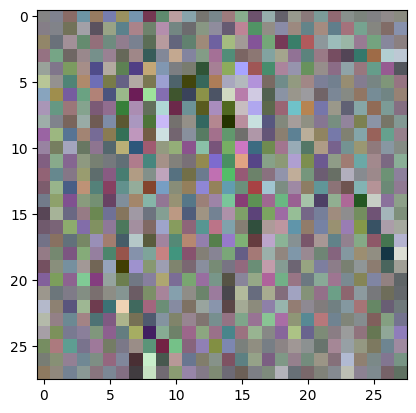

0.08121537417173386
0.08860346674919128


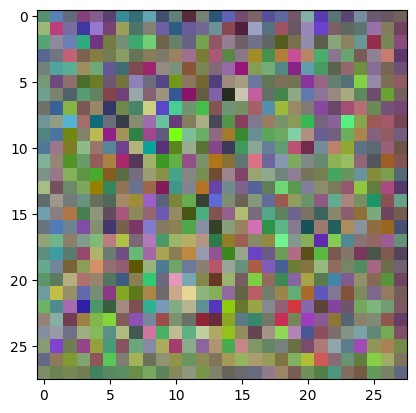

 12%|█▏        | 7/60 [00:14<01:41,  1.91s/it]

time:  1.1348388195037842


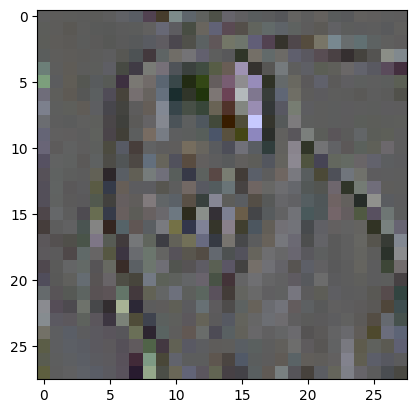

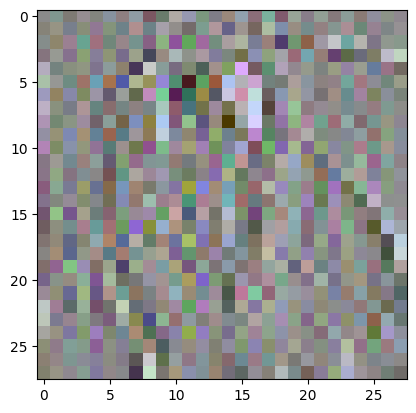

0.07523970305919647
0.08442780375480652


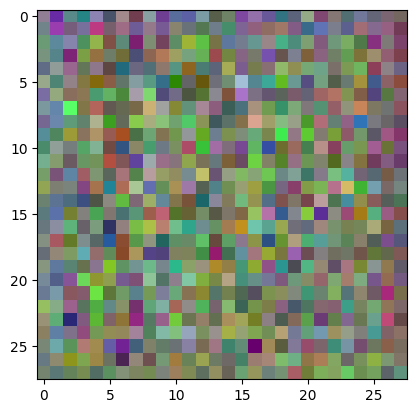

 13%|█▎        | 8/60 [00:15<01:31,  1.76s/it]

time:  1.2217092514038086


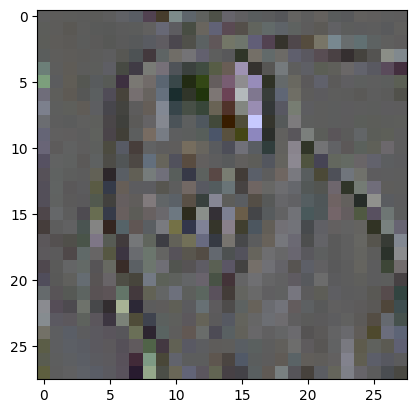

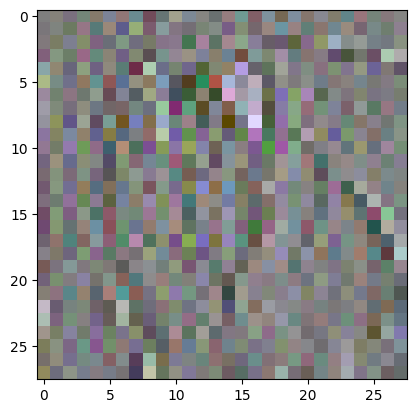

0.07193779200315475
0.07725547254085541


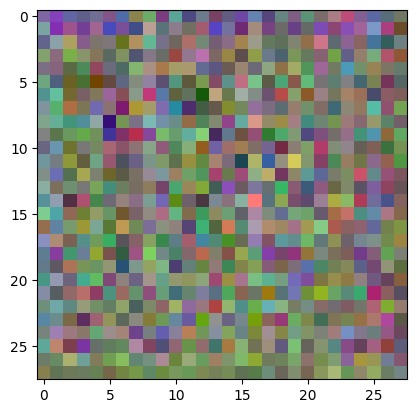

 15%|█▌        | 9/60 [00:17<01:30,  1.78s/it]

time:  1.202467441558838


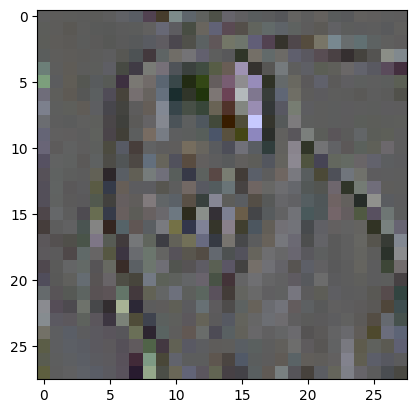

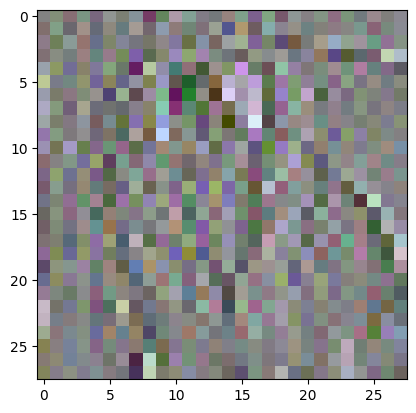

0.06767824292182922
0.07282459735870361


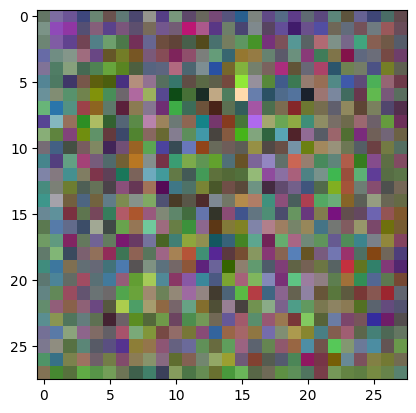

 17%|█▋        | 10/60 [00:20<01:57,  2.34s/it]

time:  1.2082116603851318


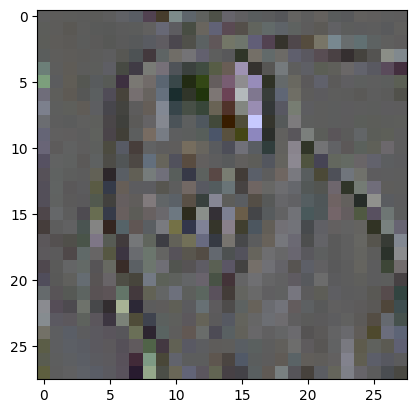

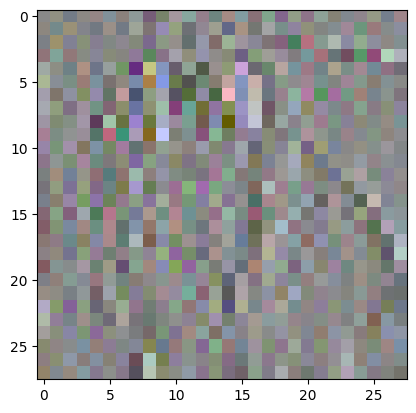

0.06921300292015076
0.07459073513746262


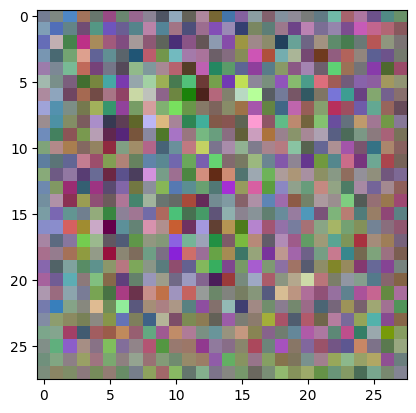

 18%|█▊        | 11/60 [00:22<01:43,  2.11s/it]

time:  1.6060450077056885


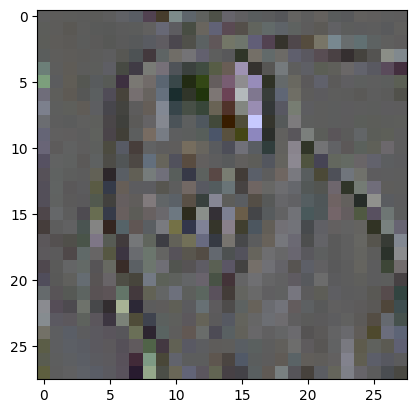

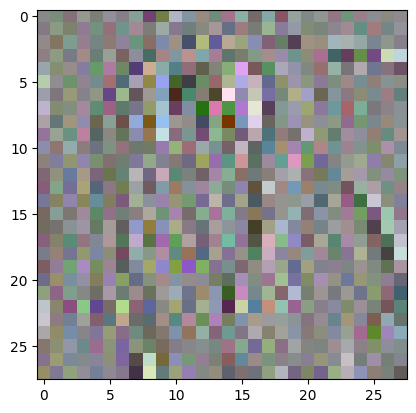

0.06457588076591492
0.06870260089635849


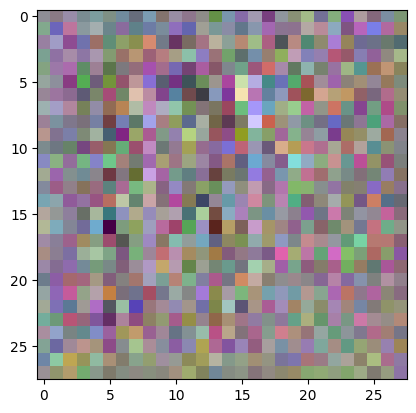

 20%|██        | 12/60 [00:24<01:44,  2.18s/it]

time:  1.1608500480651855


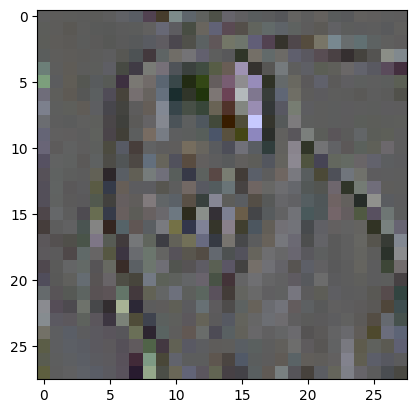

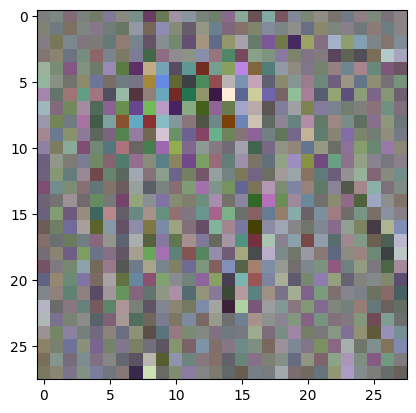

0.06454809010028839
0.06866967678070068


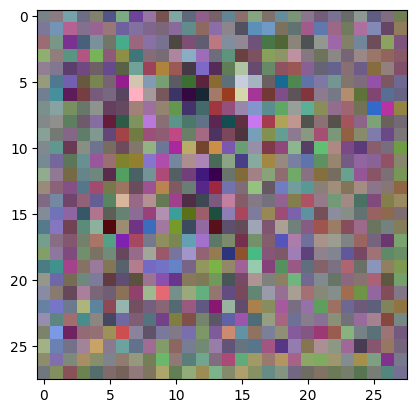

 22%|██▏       | 13/60 [00:26<01:37,  2.08s/it]

time:  1.5167357921600342


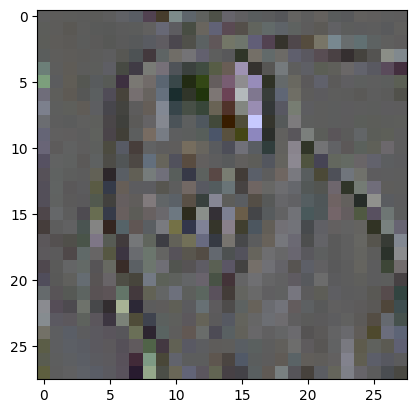

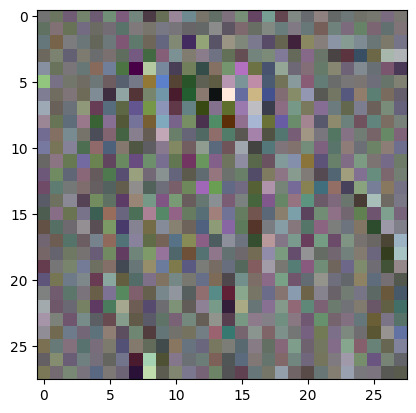

0.057950276881456375
0.0629858449101448


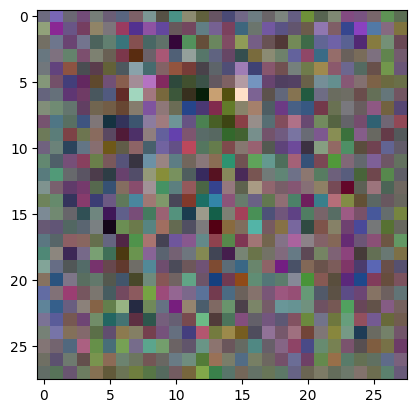

 23%|██▎       | 14/60 [00:29<01:41,  2.22s/it]

time:  1.120314359664917


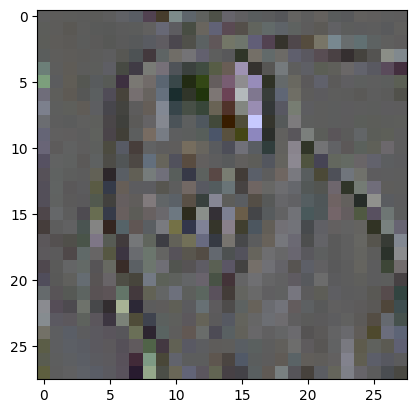

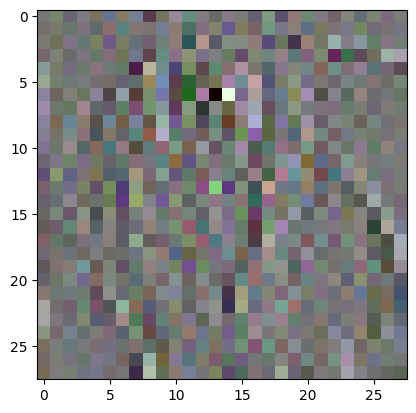

0.05731410160660744
0.060736432671546936


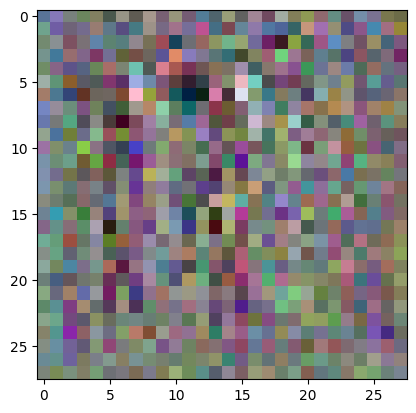

 25%|██▌       | 15/60 [00:30<01:32,  2.05s/it]

time:  1.3093595504760742


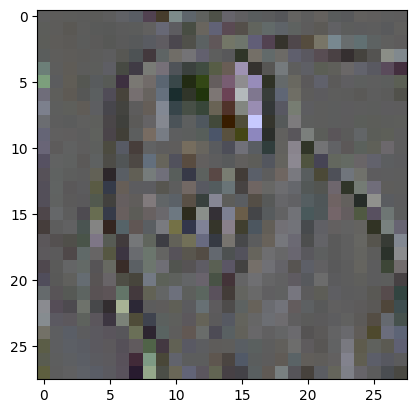

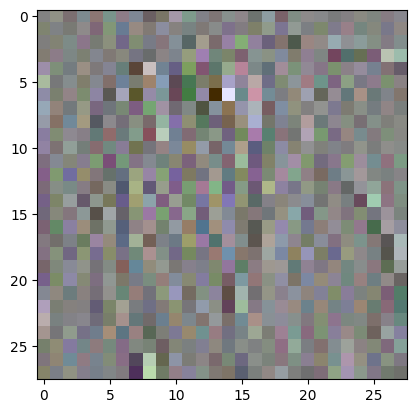

0.05895230919122696
0.061723172664642334


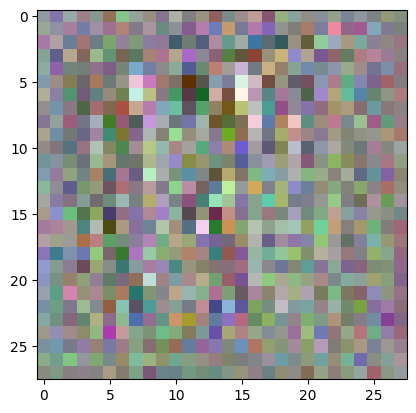

 27%|██▋       | 16/60 [00:32<01:27,  1.99s/it]

time:  1.223757028579712


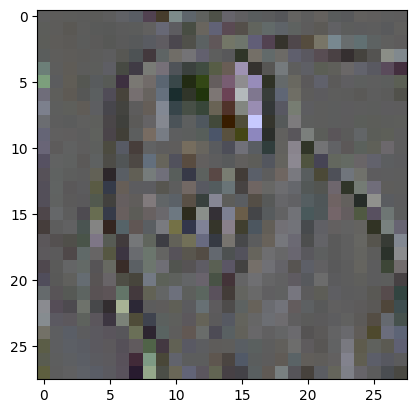

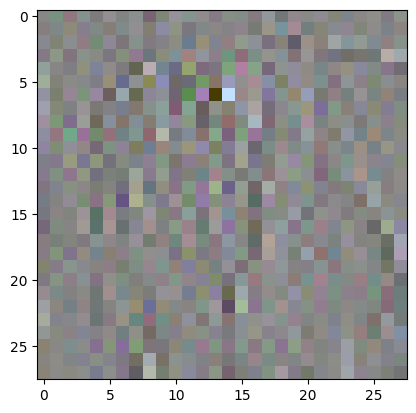

0.058234427124261856
0.061250943690538406


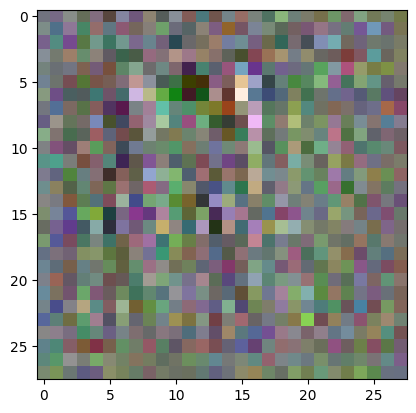

 28%|██▊       | 17/60 [00:34<01:19,  1.85s/it]

time:  1.475346565246582


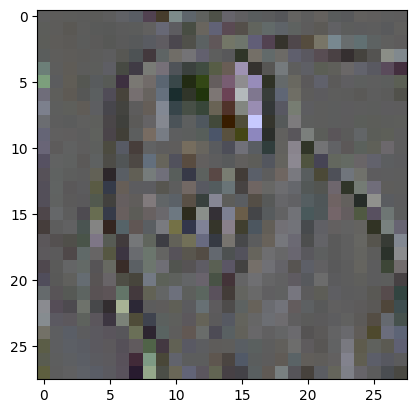

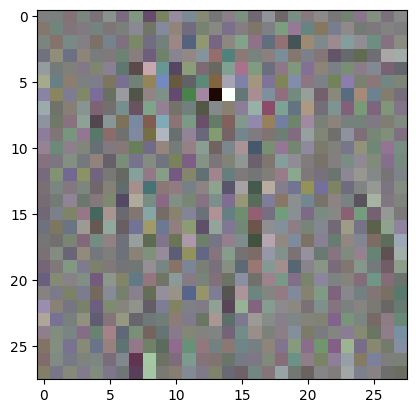

0.055609241127967834
0.058521296828985214


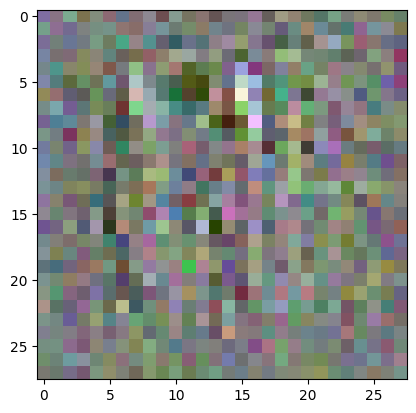

 30%|███       | 18/60 [00:36<01:24,  2.02s/it]

time:  1.1909592151641846


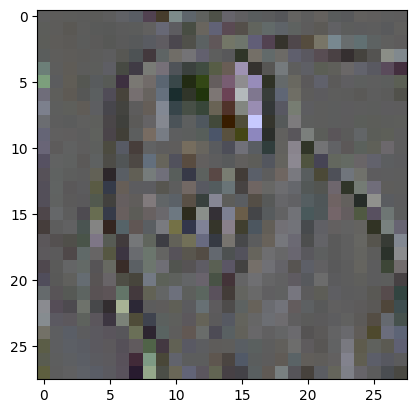

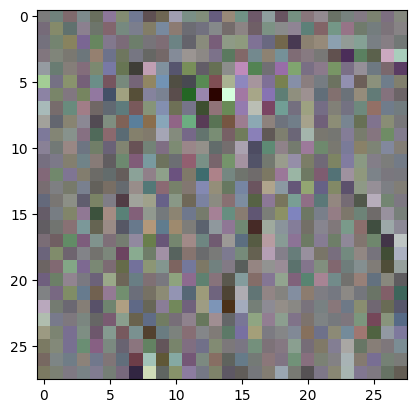

0.047989483922719955
0.050755929201841354


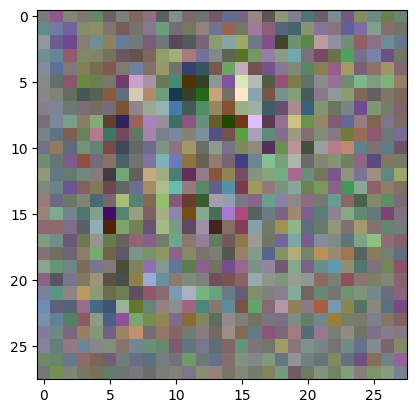

 32%|███▏      | 19/60 [00:38<01:18,  1.90s/it]

time:  1.1892879009246826


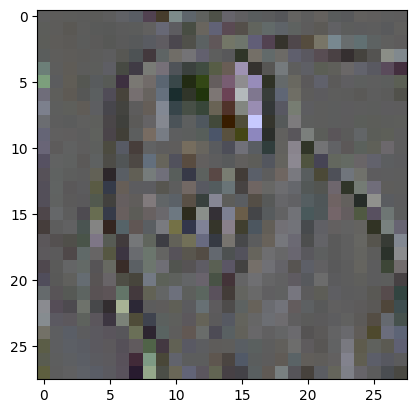

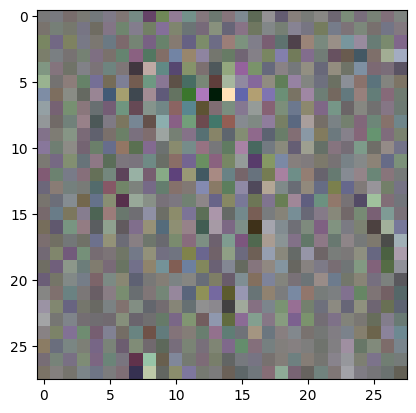

0.053879547864198685
0.05621609836816788


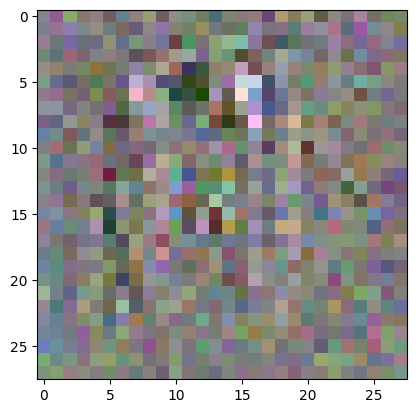

 33%|███▎      | 20/60 [00:40<01:16,  1.91s/it]

time:  1.1204400062561035


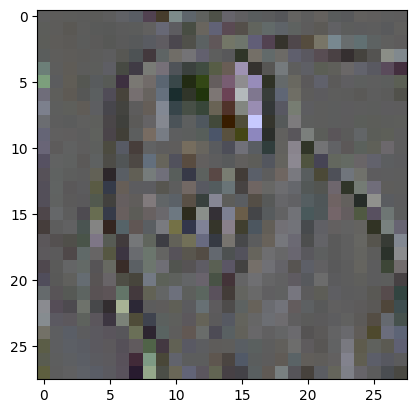

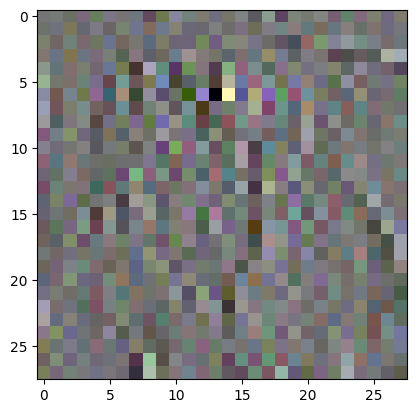

0.0507088340818882
0.053232934325933456


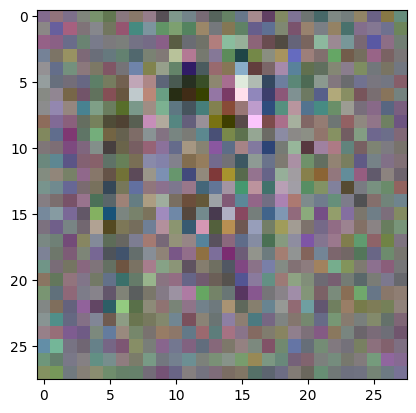

 35%|███▌      | 21/60 [00:43<01:25,  2.19s/it]

time:  1.2619366645812988


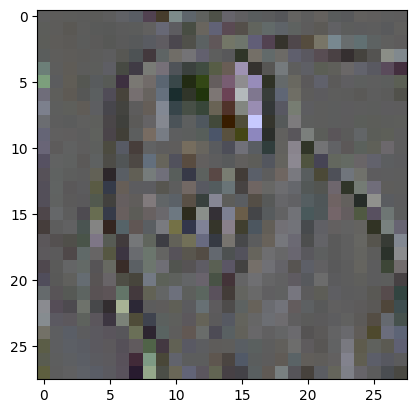

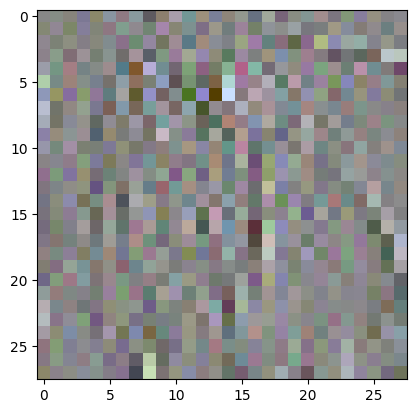

0.04787306860089302
0.04990679770708084


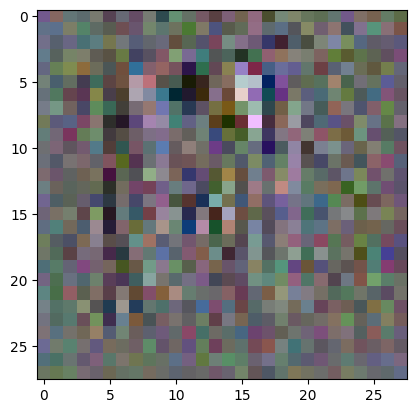

 37%|███▋      | 22/60 [00:44<01:17,  2.05s/it]

time:  1.3888881206512451


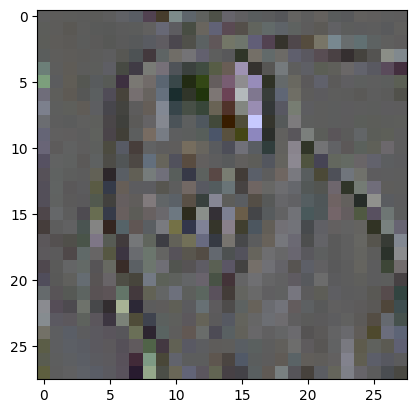

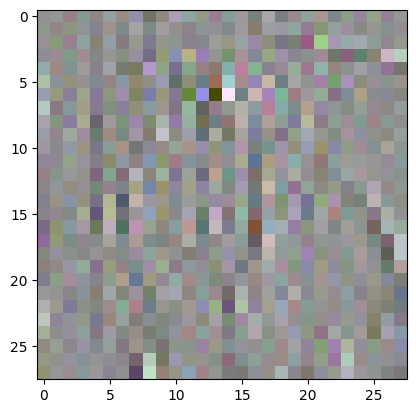

0.04867156594991684
0.05128702521324158


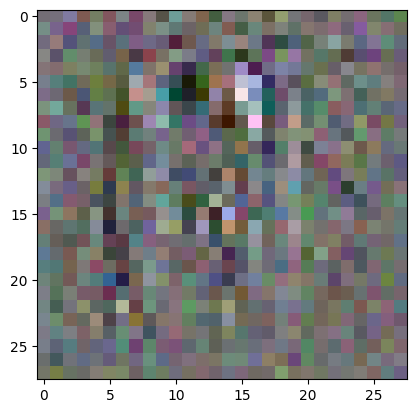

 38%|███▊      | 23/60 [00:47<01:19,  2.16s/it]

time:  1.1594161987304688


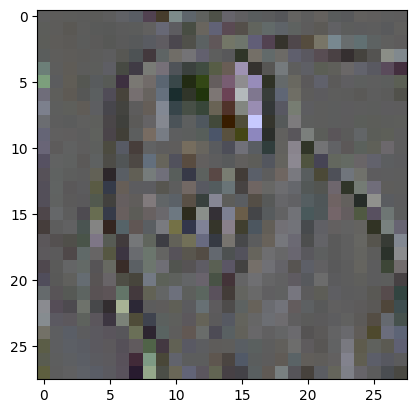

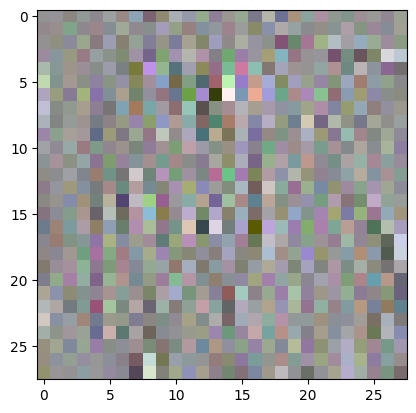

0.04762816056609154
0.05019424855709076


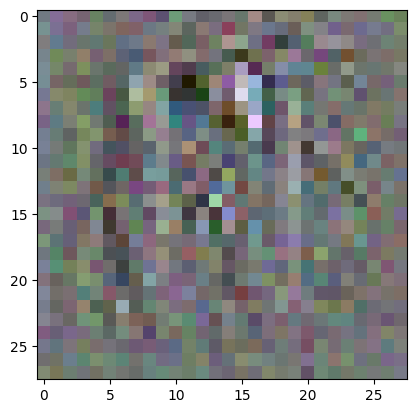

 40%|████      | 24/60 [00:48<01:10,  1.97s/it]

time:  1.3128712177276611


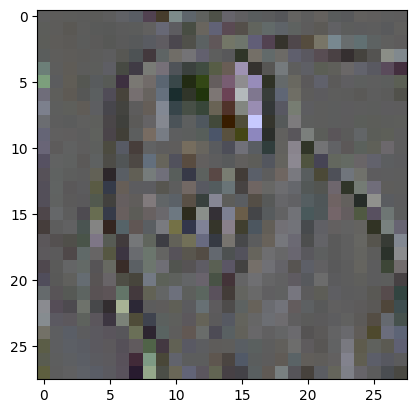

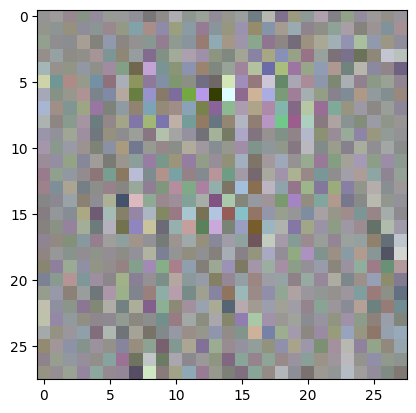

0.04762403666973114
0.049326371401548386


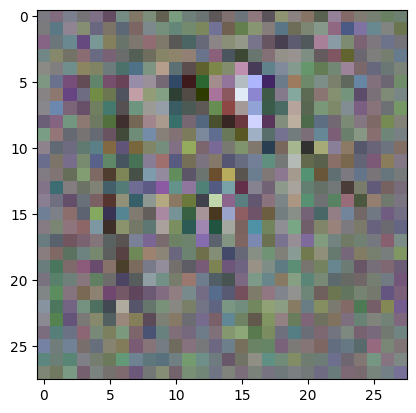

 42%|████▏     | 25/60 [00:50<01:05,  1.87s/it]

time:  1.246361494064331


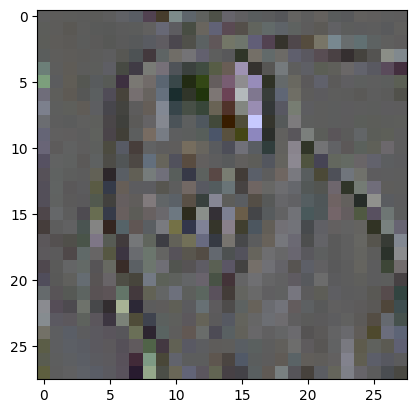

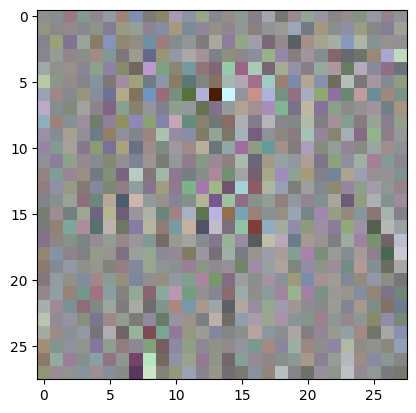

0.04401036351919174
0.04560771584510803


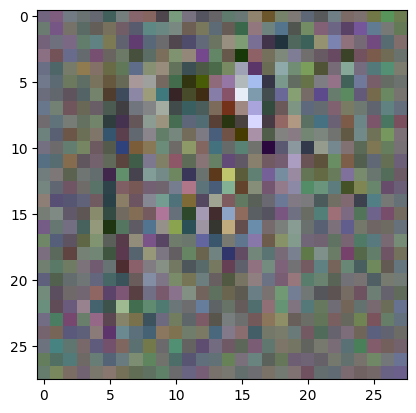

 43%|████▎     | 26/60 [00:52<01:08,  2.01s/it]

time:  1.1292386054992676


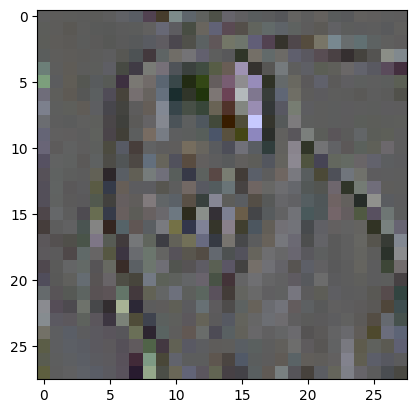

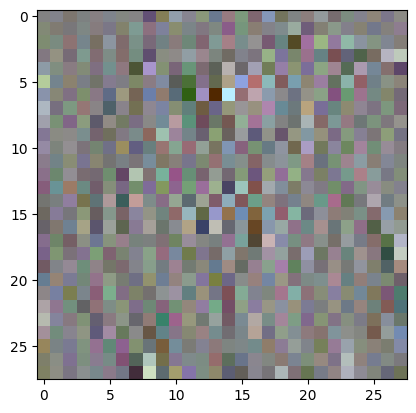

0.04056771099567413
0.042835723608732224


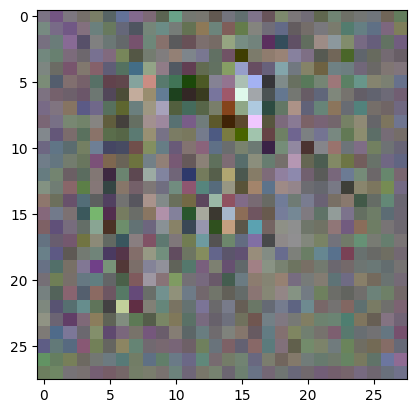

 45%|████▌     | 27/60 [00:54<01:00,  1.85s/it]

time:  1.147904396057129


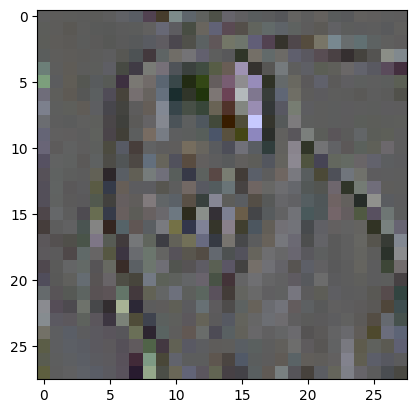

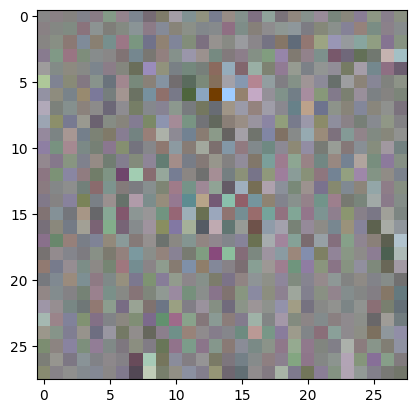

0.039390332996845245
0.04089636355638504


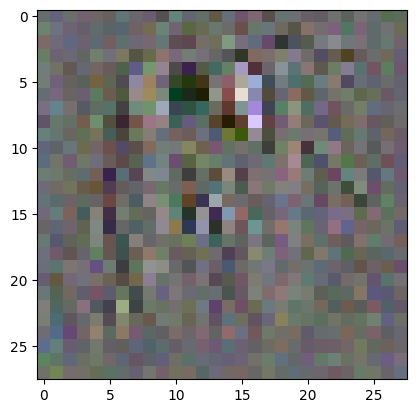

 47%|████▋     | 28/60 [00:56<00:59,  1.86s/it]

time:  1.1190555095672607


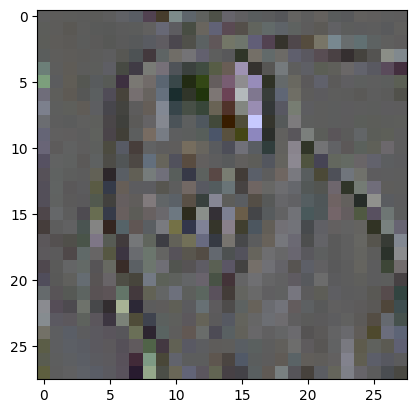

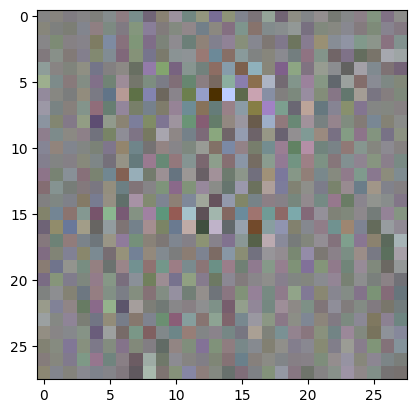

0.05138097703456879
0.05344594269990921


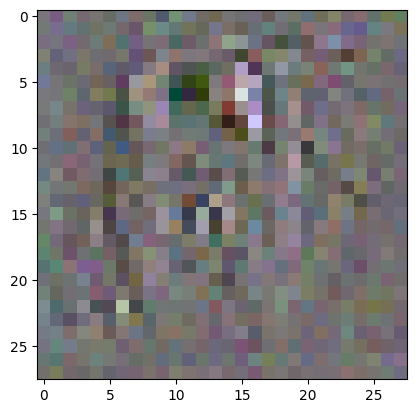

 48%|████▊     | 29/60 [00:57<00:53,  1.73s/it]

time:  1.1982879638671875


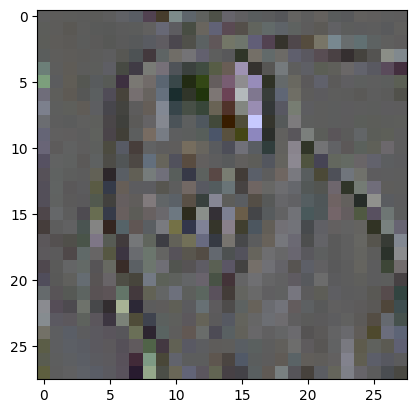

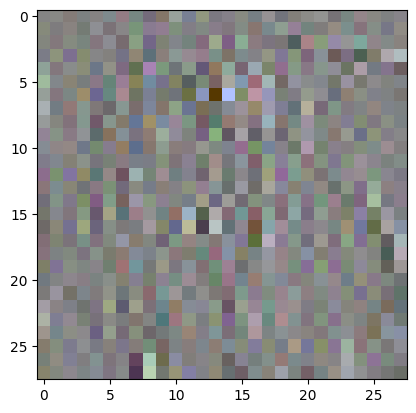

0.04196133464574814
0.04275492951273918


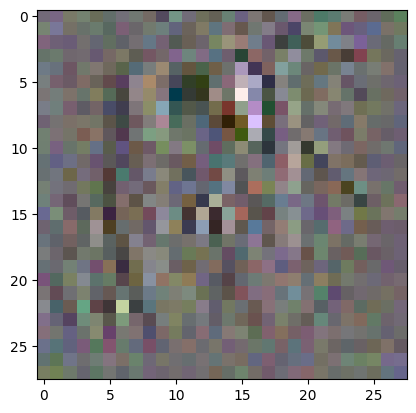

 50%|█████     | 30/60 [00:59<00:49,  1.66s/it]

time:  1.2244584560394287


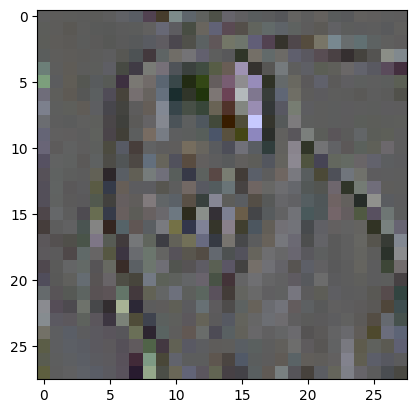

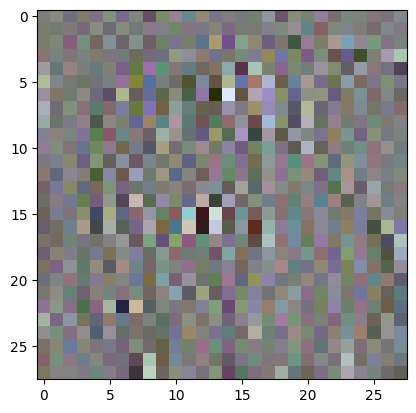

0.041000209748744965
0.04308383911848068


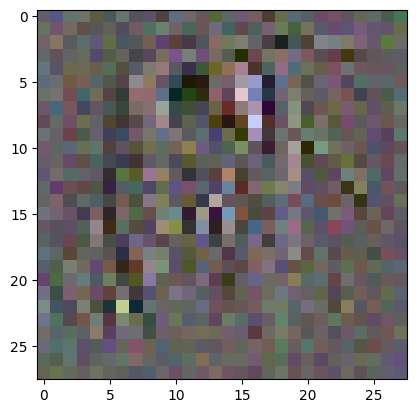

 52%|█████▏    | 31/60 [01:00<00:48,  1.67s/it]

time:  1.2571754455566406


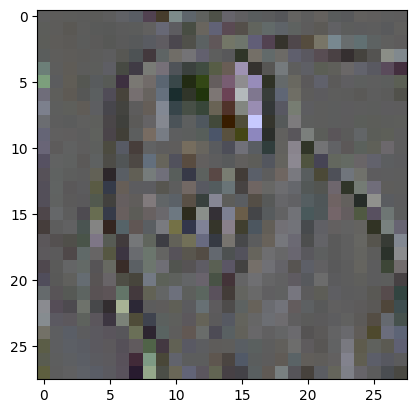

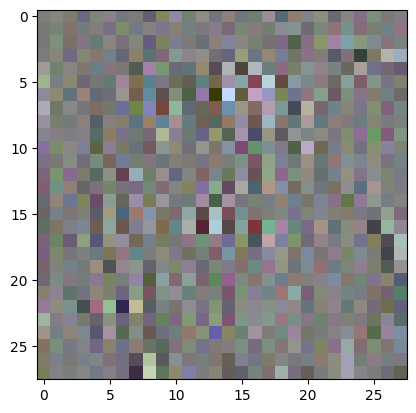

0.03915877267718315
0.04116379842162132


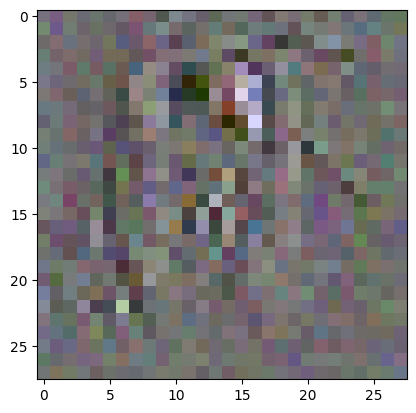

 53%|█████▎    | 32/60 [01:02<00:49,  1.75s/it]

time:  1.5231447219848633


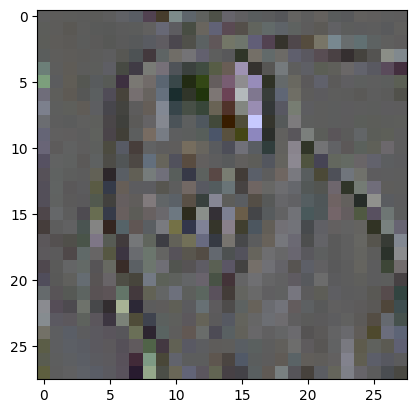

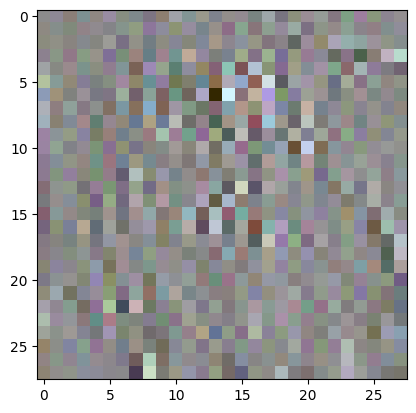

0.036341845989227295
0.037721116095781326


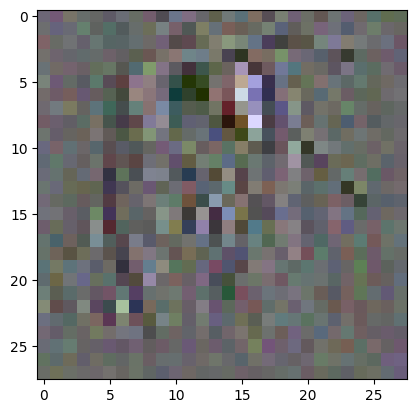

 55%|█████▌    | 33/60 [01:04<00:51,  1.91s/it]

time:  1.118549108505249


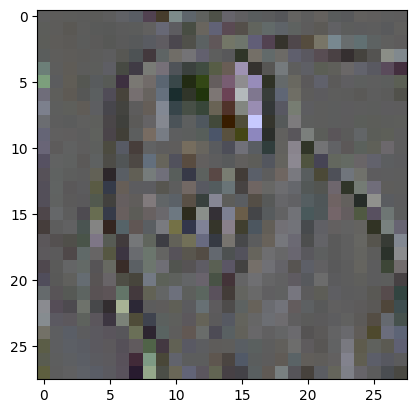

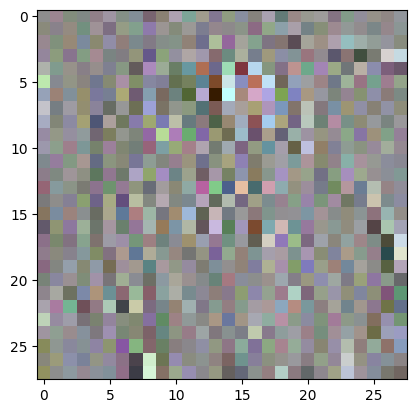

0.031844206154346466
0.03341874107718468


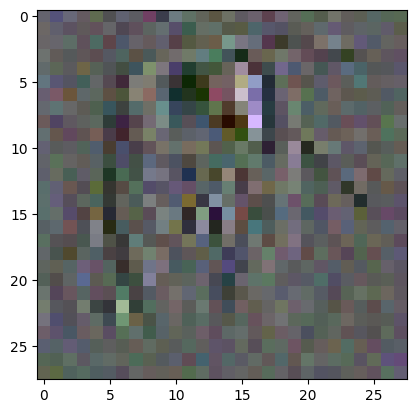

 57%|█████▋    | 34/60 [01:06<00:46,  1.78s/it]

time:  1.2445740699768066


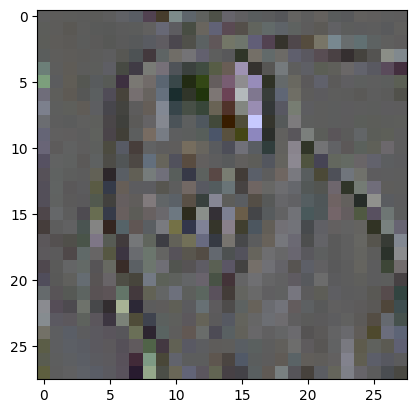

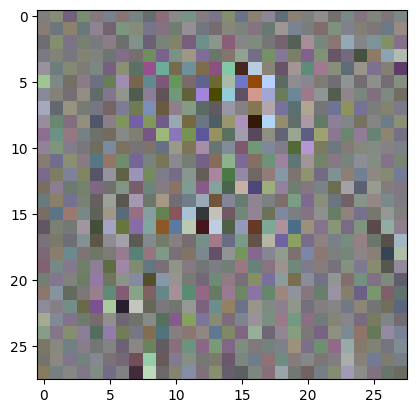

0.04309854656457901
0.04549068957567215


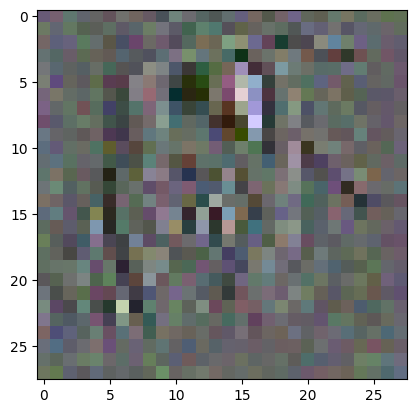

 58%|█████▊    | 35/60 [01:08<00:44,  1.76s/it]

time:  1.475947618484497


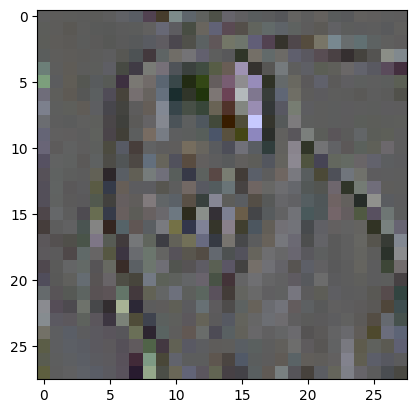

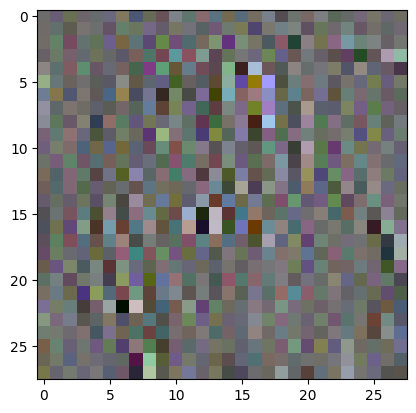

0.038702819496393204
0.0403999499976635


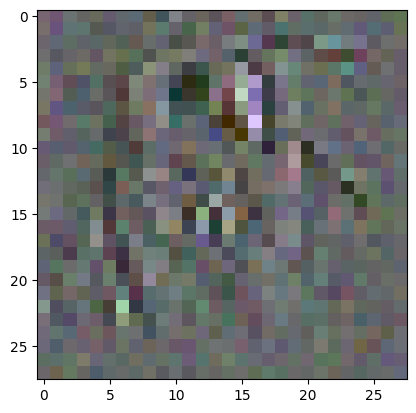

 60%|██████    | 36/60 [01:10<00:43,  1.81s/it]

time:  1.1242244243621826


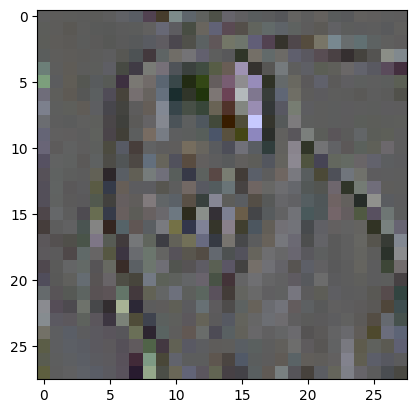

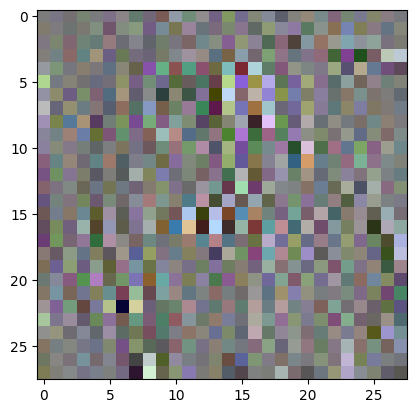

0.03508344292640686
0.0368928425014019


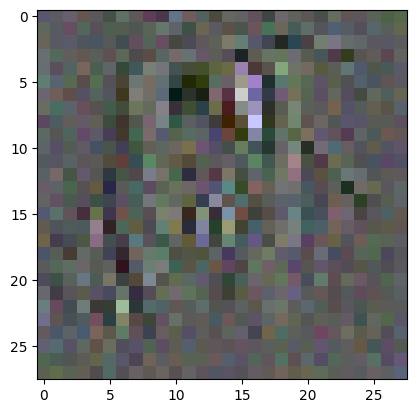

 62%|██████▏   | 37/60 [01:14<00:57,  2.51s/it]

time:  1.1296193599700928


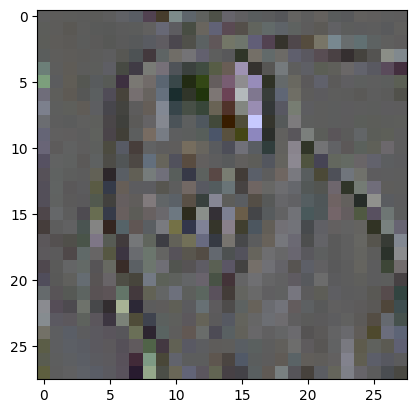

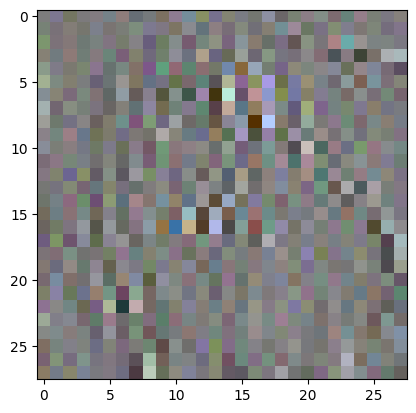

0.03495556488633156
0.036876022815704346


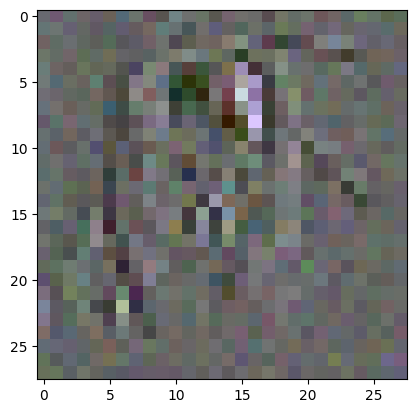

 63%|██████▎   | 38/60 [01:18<01:09,  3.17s/it]

time:  1.0862832069396973


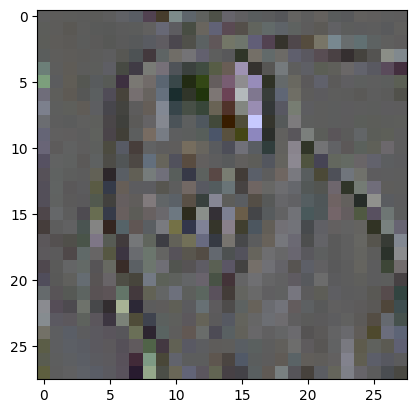

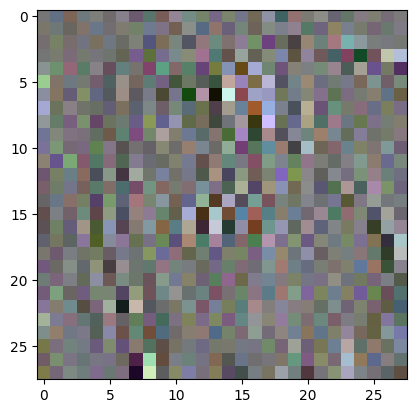

0.03108186088502407
0.03248777240514755


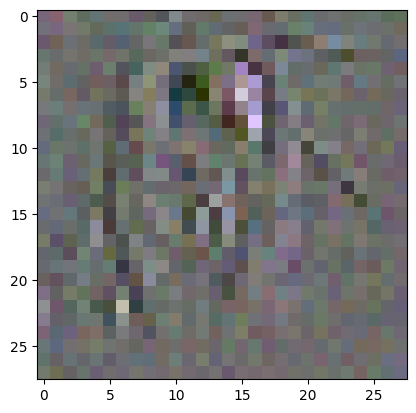

 65%|██████▌   | 39/60 [01:20<00:55,  2.63s/it]

time:  1.2728195190429688


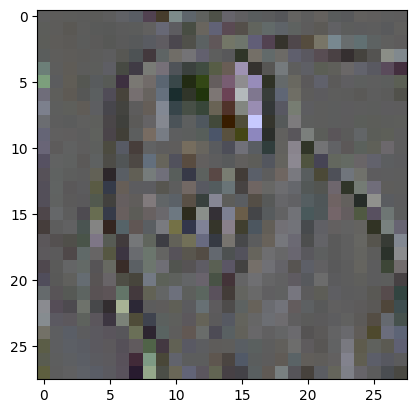

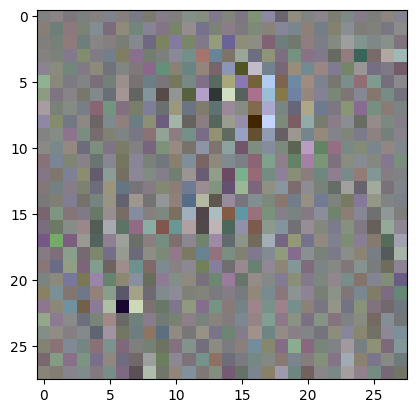

0.04399220645427704
0.045566853135824203


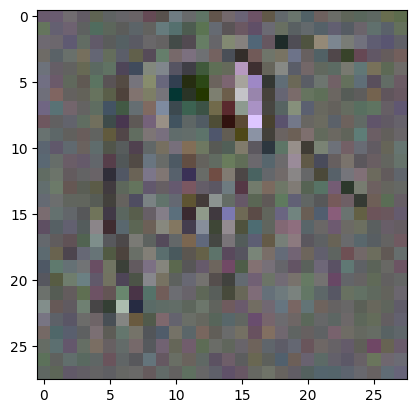

 67%|██████▋   | 40/60 [01:22<00:47,  2.36s/it]

time:  1.2427794933319092


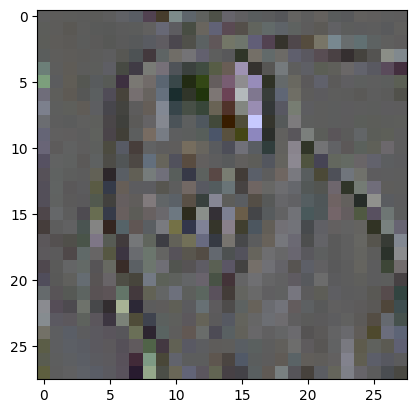

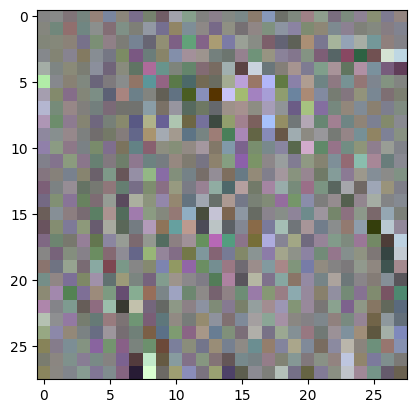

0.028653690591454506
0.03024453856050968


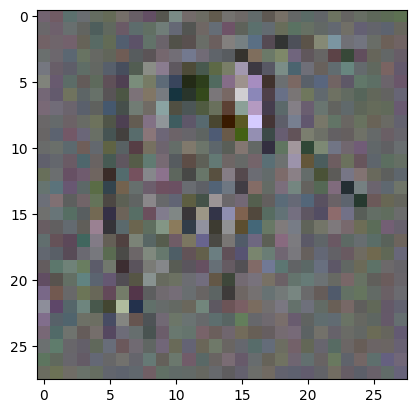

 68%|██████▊   | 41/60 [01:23<00:40,  2.13s/it]

time:  1.3784267902374268


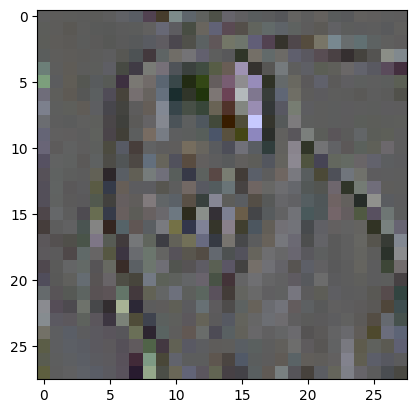

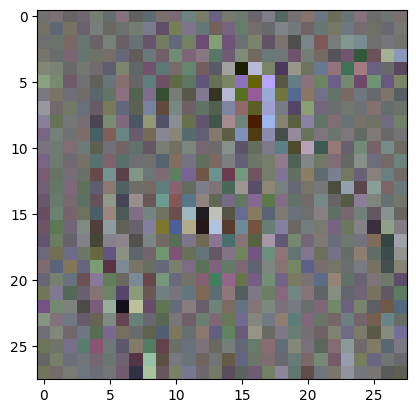

0.03796922788023949
0.03975584730505943


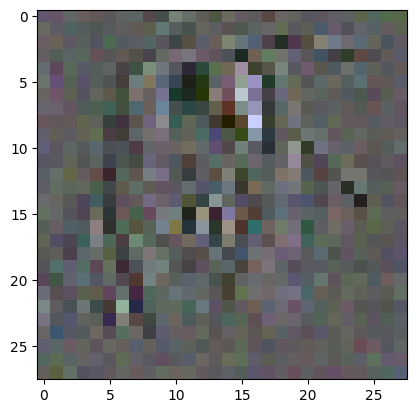

 70%|███████   | 42/60 [01:25<00:36,  2.01s/it]

time:  1.121166467666626


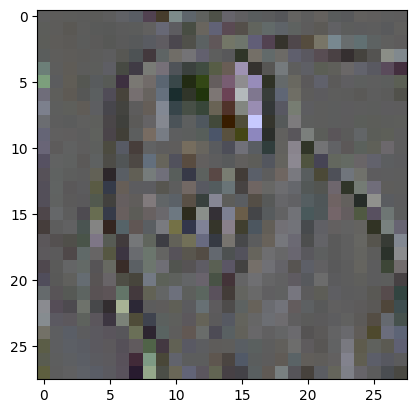

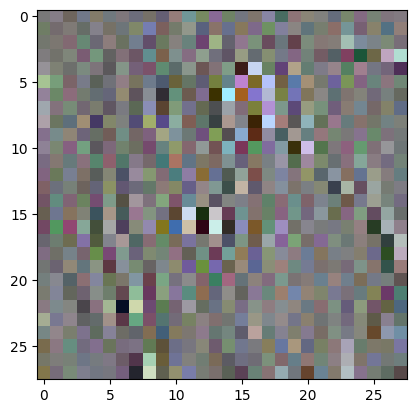

0.030677074566483498
0.03203750401735306


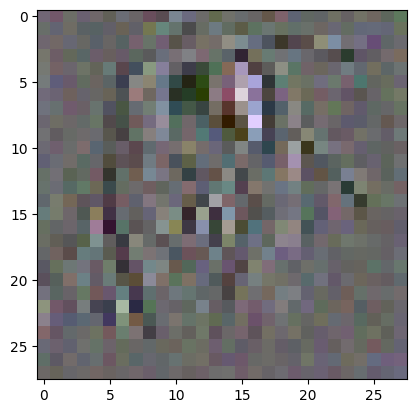

 72%|███████▏  | 43/60 [01:26<00:31,  1.87s/it]

time:  1.2823009490966797


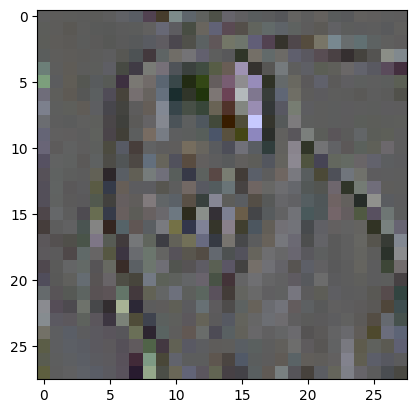

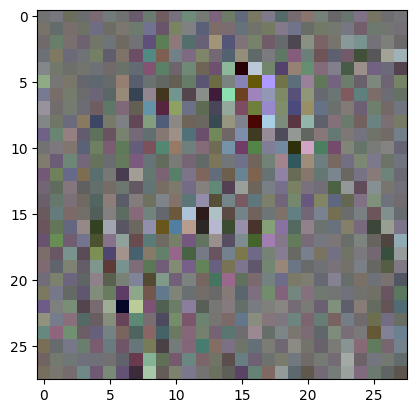

0.035771798342466354
0.03762085363268852


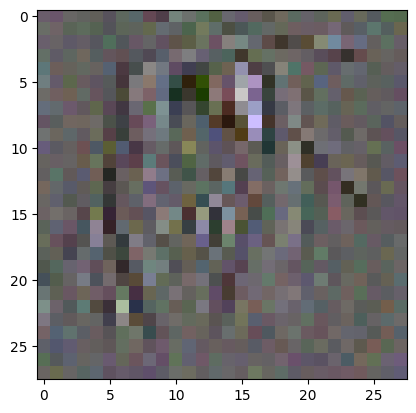

 73%|███████▎  | 44/60 [01:28<00:28,  1.80s/it]

time:  1.1679880619049072


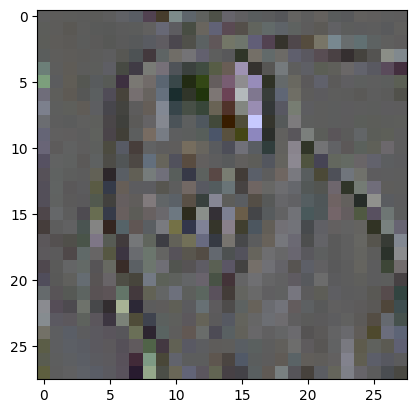

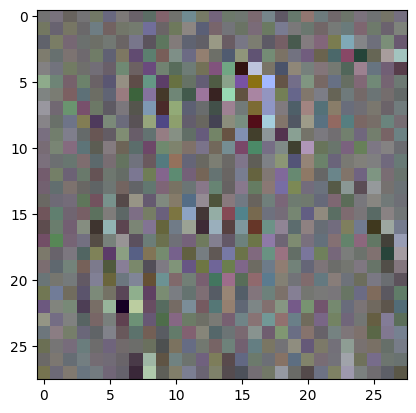

0.029466690495610237
0.03087371028959751


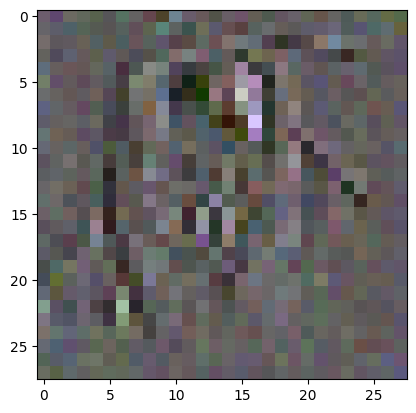

 75%|███████▌  | 45/60 [01:30<00:25,  1.71s/it]

time:  1.3972079753875732


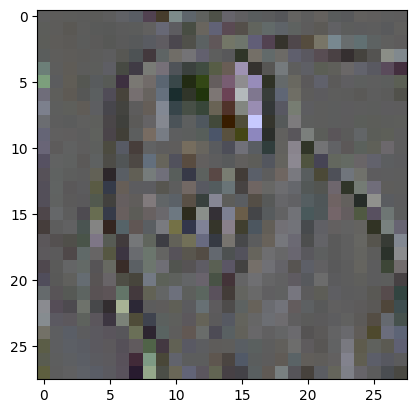

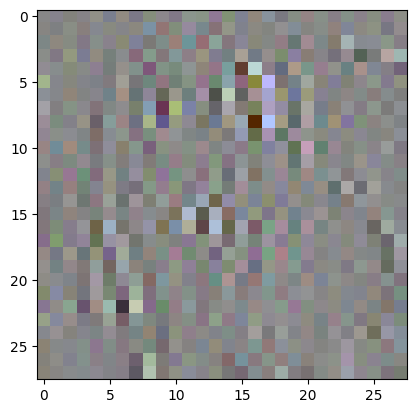

0.04377508908510208
0.04541192576289177


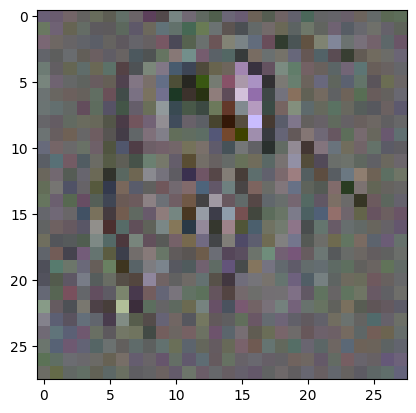

 77%|███████▋  | 46/60 [01:31<00:24,  1.75s/it]

time:  1.1683533191680908


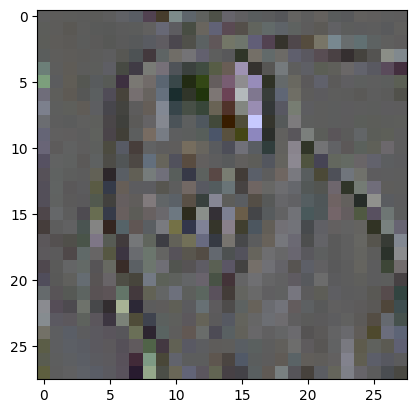

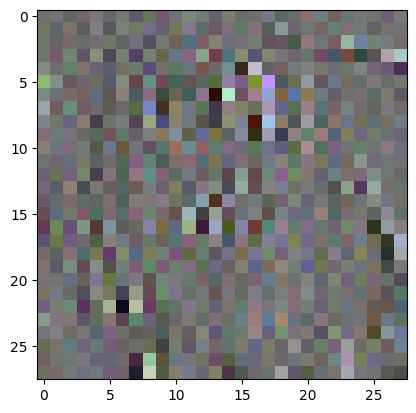

0.026558788493275642
0.027898667380213737


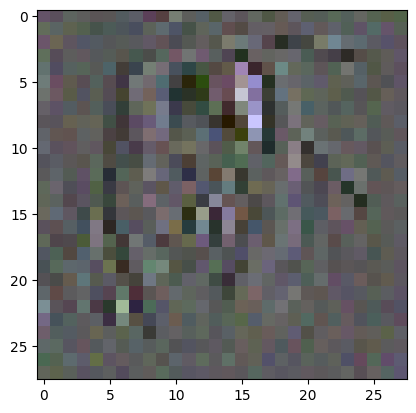

 78%|███████▊  | 47/60 [01:33<00:21,  1.66s/it]

time:  1.2503814697265625


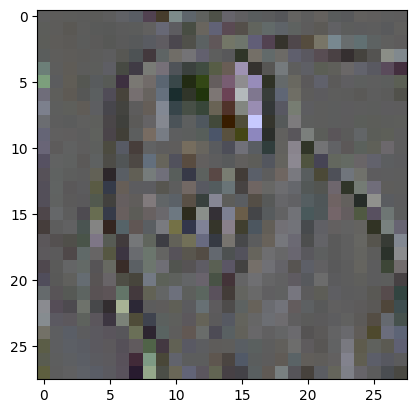

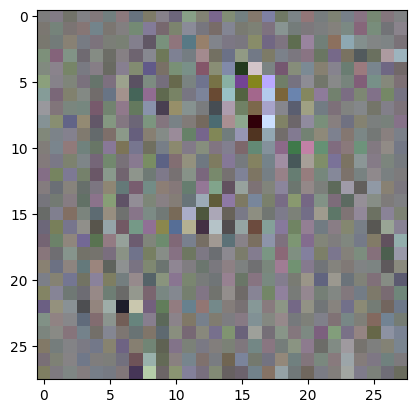

0.035525690764188766
0.03661298751831055


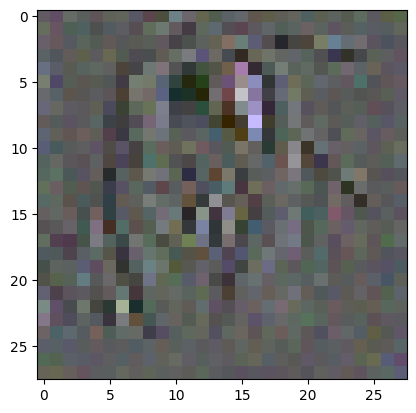

 80%|████████  | 48/60 [01:34<00:19,  1.63s/it]

time:  1.3161356449127197


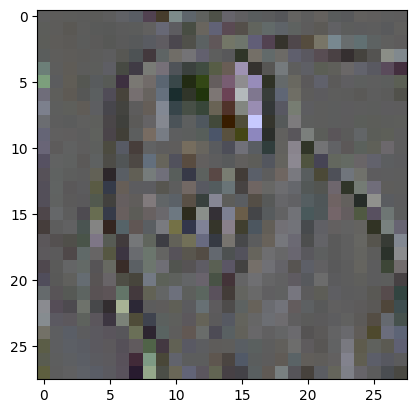

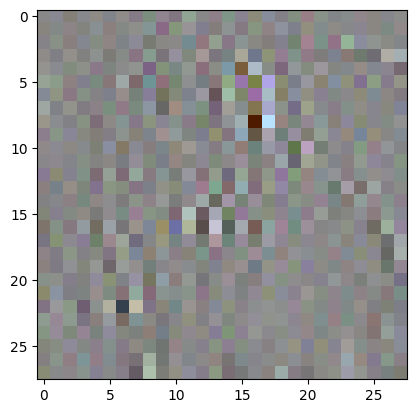

0.03575916960835457
0.037061549723148346


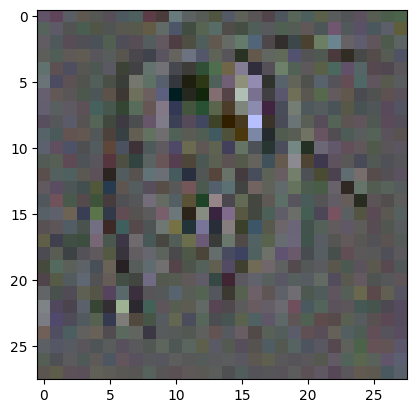

 82%|████████▏ | 49/60 [01:36<00:17,  1.62s/it]

time:  1.427536964416504


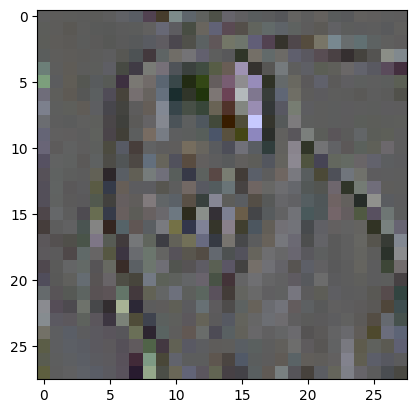

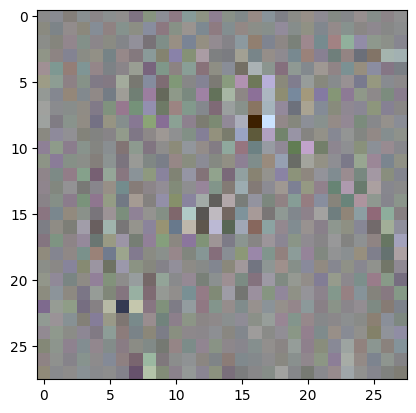

0.03490961715579033
0.03621184080839157


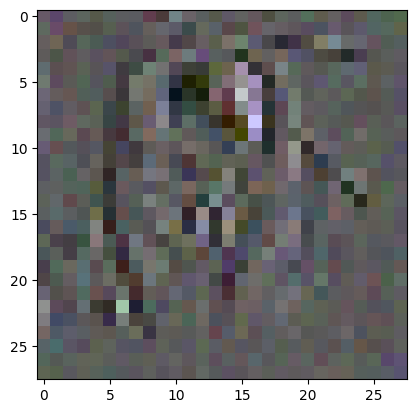

 83%|████████▎ | 50/60 [01:38<00:16,  1.65s/it]

time:  1.3491148948669434


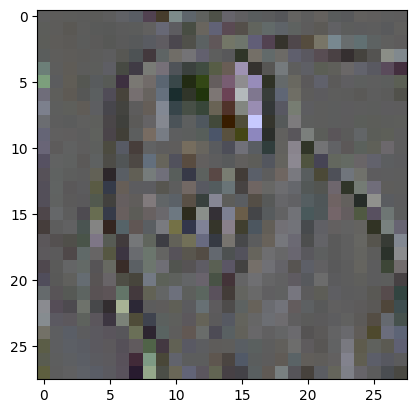

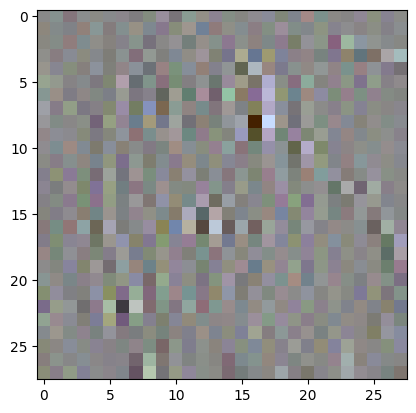

0.035078804939985275
0.03627603128552437


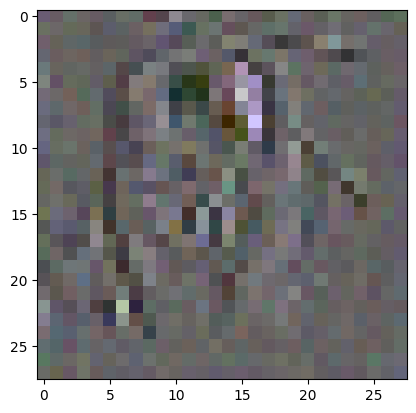

 85%|████████▌ | 51/60 [01:40<00:15,  1.70s/it]

time:  1.0655748844146729


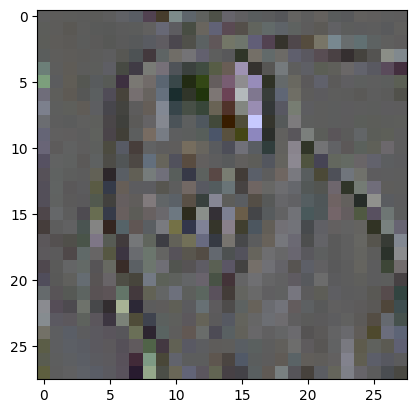

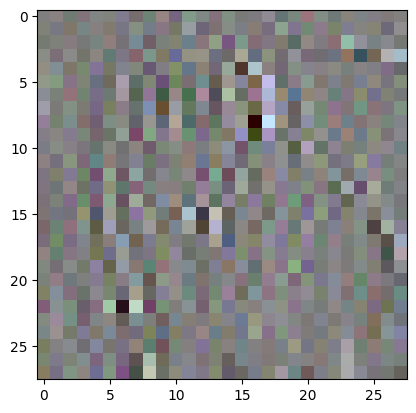

0.030364785343408585
0.031566545367240906


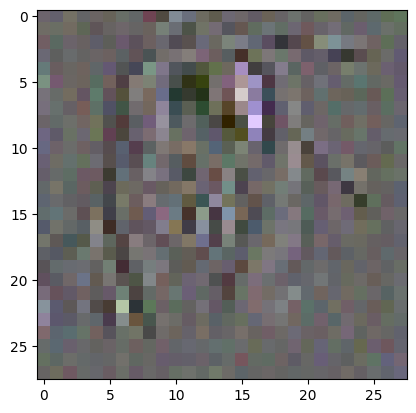

 87%|████████▋ | 52/60 [01:42<00:15,  1.95s/it]

time:  1.4467079639434814


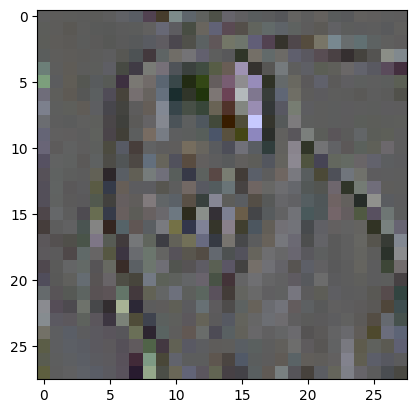

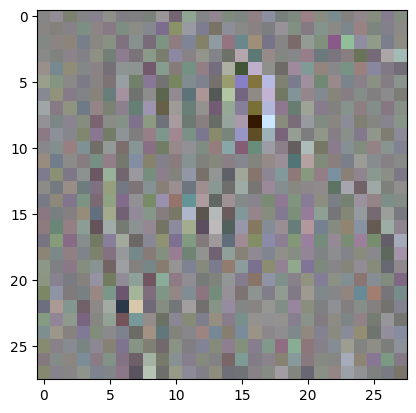

0.03695010766386986
0.03806697949767113


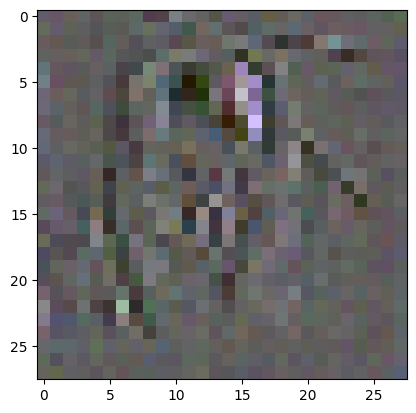

 88%|████████▊ | 53/60 [01:44<00:14,  2.00s/it]

time:  1.13411545753479


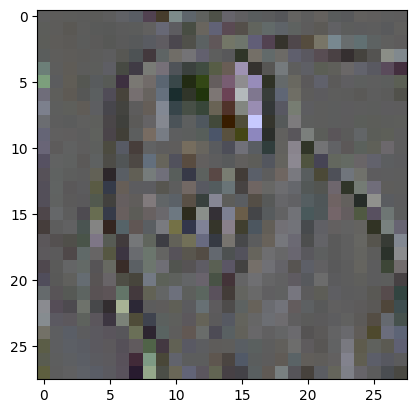

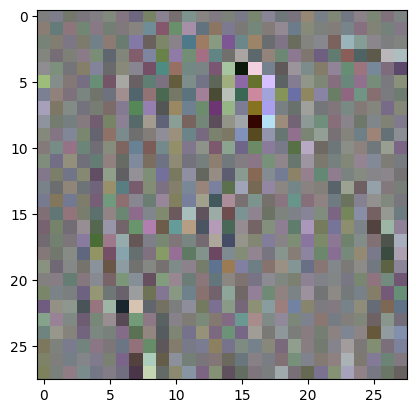

0.02762054093182087
0.02904750220477581


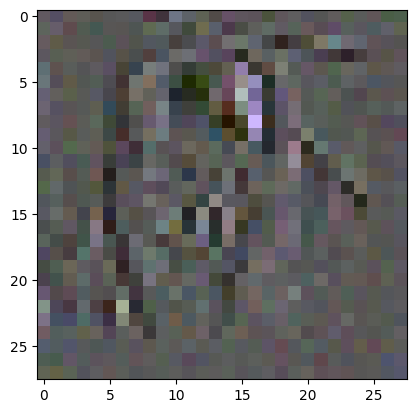

 90%|█████████ | 54/60 [01:46<00:11,  1.98s/it]

time:  1.181370496749878


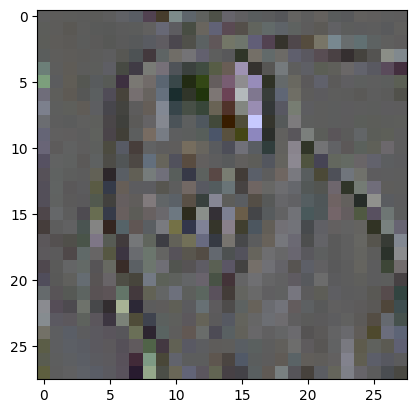

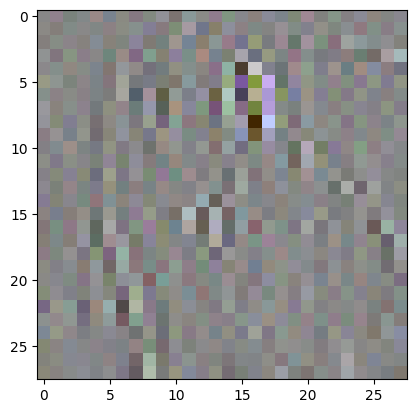

0.038151372224092484
0.039406076073646545


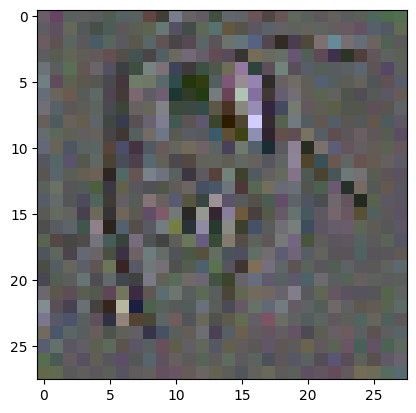

 92%|█████████▏| 55/60 [01:48<00:10,  2.04s/it]

time:  1.202859878540039


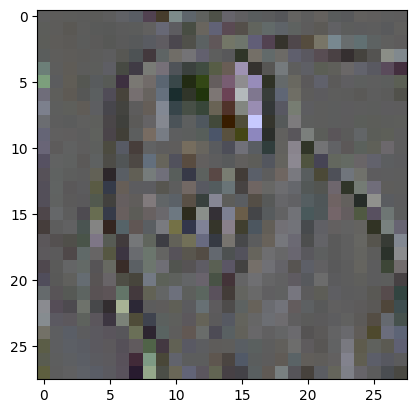

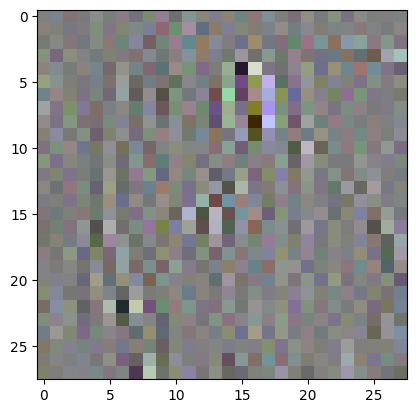

0.03593215346336365
0.03726880997419357


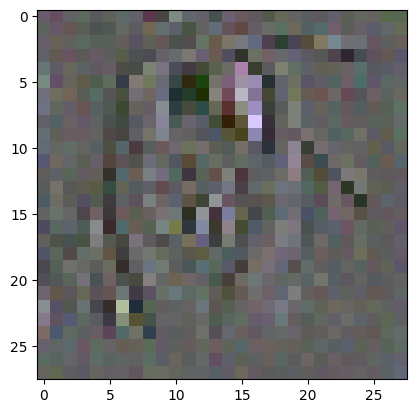

 93%|█████████▎| 56/60 [01:50<00:07,  1.88s/it]

time:  1.5109896659851074


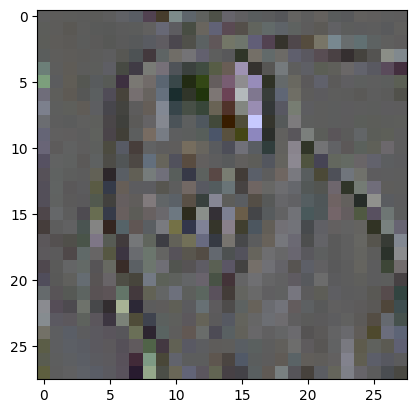

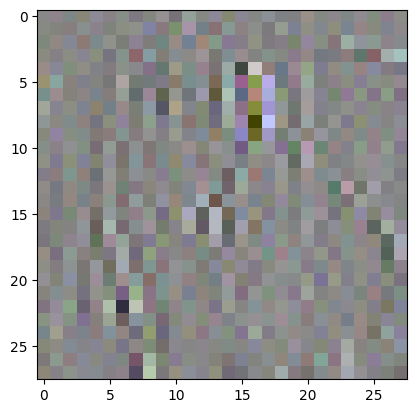

0.030460543930530548
0.03165675699710846


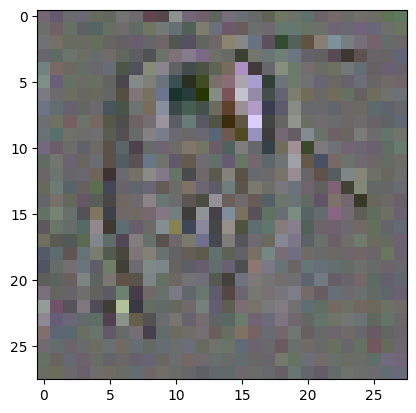

 95%|█████████▌| 57/60 [01:52<00:05,  1.96s/it]

time:  1.159311294555664


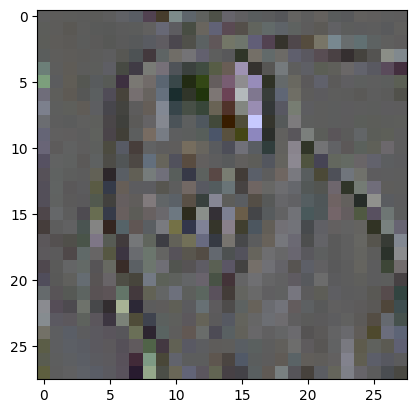

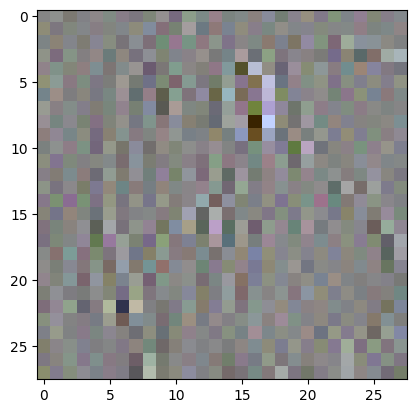

0.03046928532421589
0.031283680349588394


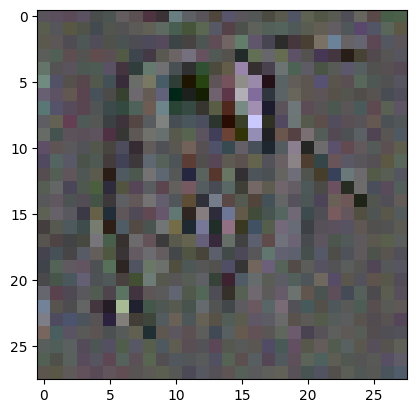

 97%|█████████▋| 58/60 [01:54<00:03,  1.88s/it]

time:  1.2853336334228516


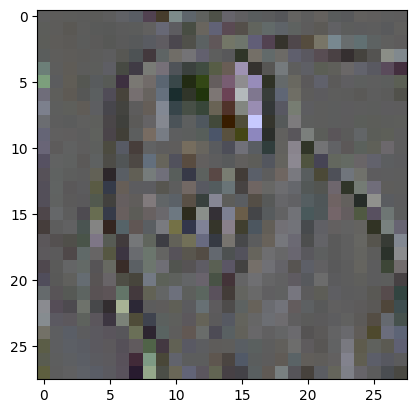

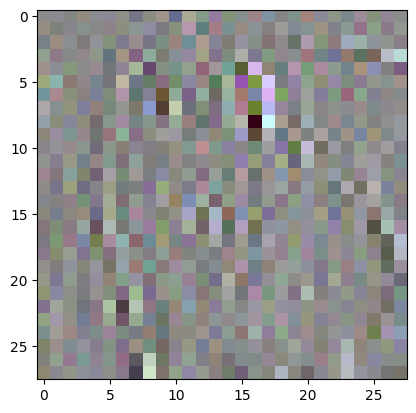

0.024693023413419724
0.026075826957821846


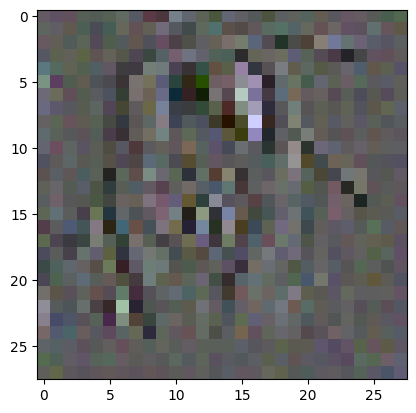

 98%|█████████▊| 59/60 [01:55<00:01,  1.80s/it]

time:  1.1291766166687012


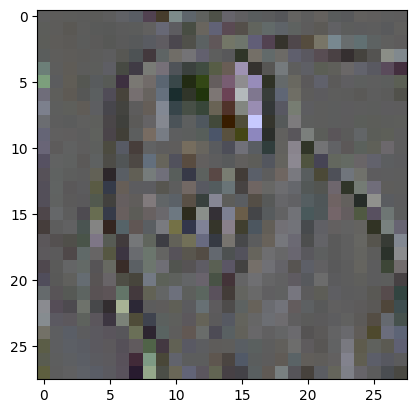

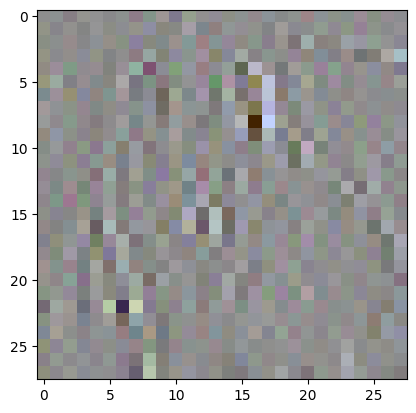

0.03608386591076851
0.03705572336912155


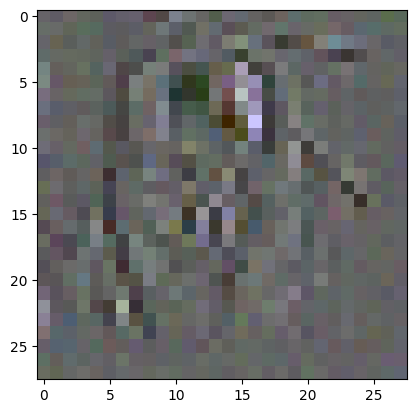

100%|██████████| 60/60 [01:57<00:00,  1.95s/it]


model has been saved


In [68]:

threads = [None] * channels
loss_c_hist = []
loss_hist = []

for e in tqdm(range(epoch)):
  x = torch.zeros((channels, N, H, W))
  m = np.zeros((channels, N, H*W), dtype=np.float32)
  del_m = np.zeros_like(m, dtype=np.float32)
  m_c = np.zeros((channels, N, int((H*W/4))), dtype=np.float32)
  # we want to sample from random time steps to construct training samples
  random_t = np.linspace([dt + eps] * n_data, [1] * n_data, N-1, axis=1)
  random_t += np.random.uniform(-dt/2, dt/2, random_t.shape)
  random_t[:, -1] = 1
  time_ = np.sort(np.insert(random_t, 0, eps, axis=1), axis=1).astype(np.float32)
  sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()
  for idx, x_ in enumerate(cifar_data):
    data = x_
    train_xc_data = torch.zeros((N, channels, int(H/2), int(W/2)))
    train_x_data = torch.zeros((N, channels, H, W))
    train_y_data = torch.zeros_like(train_x_data)
    
    # diffuse all three channels concurrently
    start = time.time()
    for i in range(channels):
      threads[i] = threading.Thread(target=diffuse, args=[data, x, m, del_m, m_c, i, train_xc_data, train_x_data, train_y_data, random_t[idx], time_[idx], sigma_[idx], idx])
      threads[i].start()
    for thread in threads:
      thread.join()
      
    print("time: ", time.time() - start)
    
    plt.imshow(np.clip((train_y_data[0] + abs(torch.min(train_y_data[0]))) / (torch.max(train_y_data[0]) + abs(torch.min(train_y_data[0]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    plt.imshow(np.clip((train_y_data[-1] + abs(torch.min(train_y_data[-1]))) / (torch.max(train_y_data[-1]) + abs(torch.min(train_y_data[-1]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    yc_pred = model_score(train_xc_data, torch.tensor(time_[idx]), coarse=True)
    lm = (2*torch.tensor(sigma_[idx])**2)[:, None, None, None]
    loss = loss_fn(yc_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_c_hist.append(losses)
    print(losses)

    y_pred = model_score(train_x_data, torch.tensor(time_[idx]))
    lm = (2*torch.tensor(sigma_[idx])**2)[:, None, None, None]
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_hist.append(losses)
    print(losses)
    scores = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, channels, H, W)) # we normalize before fedding back into PDE
    # scores[1] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    # scores[2] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    plt.imshow(np.moveaxis(np.clip((scores[0] + abs(np.min(scores[0]))) / (np.max(scores[0]) + abs(np.min(scores[0]))), 0, 1).reshape((channels, H, W)), 0, 2))
    plt.show()

torch.save(model_score.state_dict(), 'model_cifar.pth')
print(f"\nmodel has been saved")

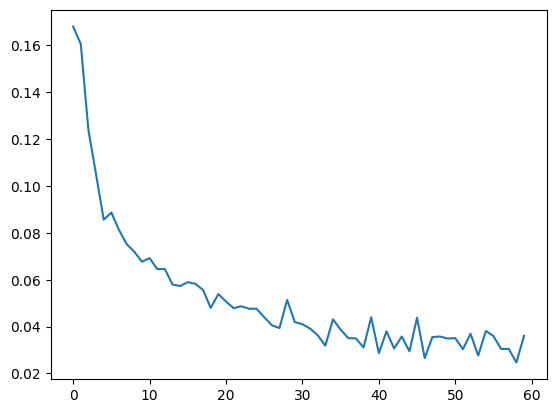

In [69]:
plt.plot(loss_c_hist);